# Averaging frames and Amorphous Calculation and fititng the peaks    


In [24]:
import re
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import numpy as np
import matplotlib.pyplot as plt

In [25]:
def set_plot_style(axs, fonts, xlabel, ylabel):
    axs.set_xlabel(xlabel, fontsize=fonts)
    axs.set_ylabel(ylabel, fontsize=fonts)
    axs.tick_params(axis='both', which='major', direction='out', length=5, width=1)
    axs.tick_params(axis='both', which='minor', direction='out', length=2.5, width=1)
    axs.tick_params(which='minor', width=1, size=2)  # Adjust size as needed
    axs.tick_params(which='major', width=1, size=4)  # Adjust size as needed
    axs.minorticks_on()  # Enable minor ticks
    #axs.grid(False, which='both', axis='both', linestyle='--', linewidth=0.5)
    axs.set_facecolor('white')
    axs.spines['top'].set_linewidth(1)
    axs.spines['right'].set_linewidth(1)
    axs.spines['bottom'].set_linewidth(1)
    axs.spines['left'].set_linewidth(1)
    axs.tick_params(axis='x', labelsize=fonts)
    axs.tick_params(axis='y', labelsize=fonts)

    return axs




import os

def read_single_file_with_keyword(folder_path, filename_search):
    file_path = os.path.join(folder_path, f"{filename_search}")

    try:
        with open(file_path, 'r') as file:
            # Read and parse the data from the file
            # Assume the data format includes 'q_nm^-1' and 'I'
            data = {
                "q_nm^-1": [],  # List of q values
                "I": [],  # List of corresponding I values
                "sigma": [],  # List of corresponding sigma values
                "I_fit": []  # List of corresponding I_fit values
            }

            # Initialize variables
            time_hr, CTEMP, I0, bstop = None, None, None, None
            lorentian_length, lorentian_scale, peak_pos, porod_exp, porod_scale = None, None, None, None, None

            for i, line in enumerate(file):
                if i == 3 and line.startswith("#"):  # Extract values from the 4th line starting with '#'
                    values_str = line[1:].strip().split(',')
                    if len(values_str) == 4:
                        values = [float(val.strip('()')) for val in values_str]
                        time_hr, CTEMP, I0, bstop = values
                    continue

                if i == 5 and line.startswith("#"):  # Extract values from the 6th line starting with '#'
                    values_str = line[1:].strip().split(',')
                    if len(values_str) == 5:
                        values = [float(val.strip('()')) for val in values_str]
                        lorentian_length, lorentian_scale, peak_pos, porod_exp, porod_scale = values
                    continue

                if line.startswith("#"):  # Skip other comments if any
                    continue


                parts = line.strip().split()  # Assuming data is whitespace-separated
                if len(parts) >= 2:
                    q_value = float(parts[0])
                    I_value = float(parts[1])
                    I_sigma = float(parts[2])
                    I_fit = float(parts[3]) 
                   

                    # Append values to the data dictionary
                    data["q_nm^-1"].append(q_value)
                    data["I"].append(I_value)
                    data["sigma"].append(I_sigma)
                    data["I_fit"].append(I_fit)

            return data, time_hr, CTEMP, I0, bstop, lorentian_length, lorentian_scale, peak_pos, porod_exp, porod_scale

    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None, None, None, None, None


import os

def read_single_file_with_keyword_general(folder_path, filename_search):
    file_path = os.path.join(folder_path, f"{filename_search}")

    try:
        with open(file_path, 'r') as file:
            # Read and parse the data from the file
            # Assume the data format includes 'q_nm^-1' and 'I'
            data = {
                "col1": [],  # List of q values
                "col2": [],  # List of corresponding I values
                "col3": [],  # List of corresponding sigma values
                "col4": []   # List of corresponding I_fit values
            }

            # Initialize parameters
            par1, par2, par3, par4, par5, par6, par7, par8, par9, par10 = None, None, None, None, None, None, None, None, None, None

            # Read the 3rd line and extract values
            for i, line in enumerate(file):
                if i == 3 and line.startswith("#"):  # Extract values from the 4th line starting with '#'
                    values_str = line[1:].strip().split(',')
                    values = [float(val.strip('()')) for val in values_str]
                    par1, par2, par3, par4, par5, par6, par7, par8, par9, par10 = values
                    continue

                if line.startswith("#"):  # Skip other comments if any
                    continue


                parts = line.strip().split()  # Assuming data is whitespace-separated
                if len(parts) >= 2:
                    q = float(parts[0])
                    I1 = float(parts[1])
                    I2 = float(parts[2])
                    I3 = float(parts[3])

                    # Append values to the data dictionary using generic column names
                    data["col1"].append(q)
                    data["col2"].append(I1)
                    data["col3"].append(I2)
                    data["col4"].append(I3)

            # Return the data dictionary and other parameters
            return data, par1, par2, par3, par4, par5, par6, par7, par8, par9, par10

    except FileNotFoundError:
        print(f"File not found: {file_path}")
        # Return None for all parameters in case of file not found
        return None, None, None, None, None, None, None, None, None, None



import os
import re

def search_dat_files_with_keywords(folder_path, keyword):
    # Create a regular expression pattern to match the keyword and bkg_keyword in the filename
    pattern = re.compile(f"{keyword}", re.IGNORECASE)

    matching_dat_files = []

    # List files in the folder (not including subfolders)
    for file in os.listdir(folder_path):
        if pattern.match(file) and file.endswith('.dat'):
            matching_dat_files.append(file)

    #print(f"Found {len(matching_dat_files)} files matching the pattern '{pattern.pattern}'")
    return matching_dat_files





def darken_colors(num_colors, darker_factor=0.65):
    """
    Darken a set of colors by reducing the value component in the HSV color space.

    Parameters:
    - num_colors (int): Number of colors to generate.
    - darker_factor (float): Factor to control the darkness of the colors. Default is 0.7.

    Returns:
    - darker_colors (numpy.ndarray): Darkened colors in RGB format.
    """
    colors = plt.cm.jet(np.linspace(0, 1, num_colors))

    # Make the colors darker by reducing the value component
    darker_colors = colors.copy()

    for i in range(num_colors):
        rgb = darker_colors[i, :3]  # Extract the RGB values
        hsv = plt.cm.colors.rgb_to_hsv(rgb)  # Convert RGB to HSV
        hsv[2] *= darker_factor  # Reduce the value component
        darker_colors[i, :3] = plt.cm.colors.hsv_to_rgb(hsv)  # Convert back to RGB

    return darker_colors

# Step 2: Amorphous Calibration and Peak fitting


function for Amorphus fraction determination

In [26]:
# -*- coding: utf-8 -*-
"""
Created on Wed Dec 30 16:05:47 2015

@author: M Wieser

LICENCE
This program is free software: you can redistribute it and/or modify
it under the terms of the GNU Lesser General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU Lesser General Public License for more details.

You should have received a copy of the GNU Lesser General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>
"""


import numpy as np
from scipy.sparse.linalg import spsolve
from scipy.linalg import cholesky
# from scikits.sparse.cholmod import cholesky
from scipy import sparse

from scipy.stats import norm
import matplotlib.pyplot as pl


def als(y, lam=1e6, p=0.1, itermax=10):
    r"""
    Implements an Asymmetric Least Squares Smoothing
    baseline correction algorithm (P. Eilers, H. Boelens 2005)

    Baseline Correction with Asymmetric Least Squares Smoothing
    based on https://github.com/vicngtor/BaySpecPlots

    Baseline Correction with Asymmetric Least Squares Smoothing
    Paul H. C. Eilers and Hans F.M. Boelens
    October 21, 2005

    Description from the original documentation:

    Most baseline problems in instrumental methods are characterized by a smooth
    baseline and a superimposed signal that carries the analytical information: a series
    of peaks that are either all positive or all negative. We combine a smoother
    with asymmetric weighting of deviations from the (smooth) trend get an effective
    baseline estimator. It is easy to use, fast and keeps the analytical peak signal intact.
    No prior information about peak shapes or baseline (polynomial) is needed
    by the method. The performance is illustrated by simulation and applications to
    real data.


    Inputs:
        y:
            input data (i.e. chromatogram of spectrum)
        lam:
            parameter that can be adjusted by user. The larger lambda is,
            the smoother the resulting background, z
        p:
            wheighting deviations. 0.5 = symmetric, <0.5: negative
            deviations are stronger suppressed
        itermax:
            number of iterations to perform
    Output:
        the fitted background vector

    """
    L = len(y)
#  D = sparse.csc_matrix(np.diff(np.eye(L), 2))
    D = sparse.eye(L, format='csc')
    D = D[1:] - D[:-1]  # numpy.diff( ,2) does not work with sparse matrix. This is a workaround.
    D = D[1:] - D[:-1]
    D = D.T
    w = np.ones(L)
    for i in range(itermax):
        W = sparse.diags(w, 0, shape=(L, L))
        Z = W + lam * D.dot(D.T)
        z = spsolve(Z, w * y)
        w = p * (y > z) + (1 - p) * (y < z)
    return z


def arpls(y, lam=1e4, ratio=0.05, itermax=100):
    r"""
    Baseline correction using asymmetrically
    reweighted penalized least squares smoothing
    Sung-June Baek, Aaron Park, Young-Jin Ahna and Jaebum Choo,
    Analyst, 2015, 140, 250 (2015)

    Abstract

    Baseline correction methods based on penalized least squares are successfully
    applied to various spectral analyses. The methods change the weights iteratively
    by estimating a baseline. If a signal is below a previously fitted baseline,
    large weight is given. On the other hand, no weight or small weight is given
    when a signal is above a fitted baseline as it could be assumed to be a part
    of the peak. As noise is distributed above the baseline as well as below the
    baseline, however, it is desirable to give the same or similar weights in
    either case. For the purpose, we propose a new weighting scheme based on the
    generalized logistic function. The proposed method estimates the noise level
    iteratively and adjusts the weights correspondingly. According to the
    experimental results with simulated spectra and measured Raman spectra, the
    proposed method outperforms the existing methods for baseline correction and
    peak height estimation.

    Inputs:
        y:
            input data (i.e. chromatogram of spectrum)
        lam:
            parameter that can be adjusted by user. The larger lambda is,
            the smoother the resulting background, z
        ratio:
            wheighting deviations: 0 < ratio < 1, smaller values allow less negative values
        itermax:
            number of iterations to perform
    Output:
        the fitted background vector

    """
    N = len(y)
#  D = sparse.csc_matrix(np.diff(np.eye(N), 2))
    D = sparse.eye(N, format='csc')
    D = D[1:] - D[:-1]  # numpy.diff( ,2) does not work with sparse matrix. This is a workaround.
    D = D[1:] - D[:-1]

    H = lam * D.T * D
    w = np.ones(N)
    for i in range(itermax):
        W = sparse.diags(w, 0, shape=(N, N))
        WH = sparse.csc_matrix(W + H)
        C = sparse.csc_matrix(cholesky(WH.todense()))
        z = spsolve(C, spsolve(C.T, w * y))
        d = y - z
        dn = d[d < 0]
        m = np.mean(dn)
        s = np.std(dn)
        wt = 1. / (1 + np.exp(2 * (d - (2 * s - m)) / s))
        if np.linalg.norm(w - wt) / np.linalg.norm(w) < ratio:
            break
        w = wt
    return z



def WhittakerSmooth(x, w, lam, differences=1):
    '''
    Penalized least squares algorithm for background fitting

    input
        x:
            input data (i.e. chromatogram of spectrum)
        w:
            binary masks (value of the mask is zero if a point belongs to peaks
            and one otherwise)
        lam:
            parameter that can be adjusted by user. The larger lambda is,  the
            smoother the resulting background
        differences:
            integer indicating the order of the difference of penalties

    output:
        the fitted background vector
    '''
    X = np.matrix(x)
    m = X.size
#    D = csc_matrix(np.diff(np.eye(m), differences))
    D = sparse.eye(m, format='csc')
    for i in range(differences):
        D = D[1:] - D[:-1]  # numpy.diff() does not work with sparse matrix. This is a workaround.
    W = sparse.diags(w, 0, shape=(m, m))
    A = sparse.csc_matrix(W + (lam * D.T * D))
    B = sparse.csc_matrix(W * X.T)
    background = spsolve(A, B)
    return np.array(background)



def airpls(x, lam=100, porder=1, itermax=100):
    '''
    airpls.py Copyright 2014 Renato Lombardo - renato.lombardo@unipa.it
    Baseline correction using adaptive iteratively reweighted penalized least squares

    This program is a translation in python of the R source code of airPLS version 2.0
    by Yizeng Liang and Zhang Zhimin - https://code.google.com/p/airpls
    Reference:
    Z.-M. Zhang, S. Chen, and Y.-Z. Liang, Baseline correction using adaptive
    iteratively reweighted penalized least squares. Analyst 135 (5), 1138-1146 (2010).

    Description from the original documentation:

    Baseline drift always blurs or even swamps signals and deteriorates analytical
    results, particularly in multivariate analysis.  It is necessary to correct
    baseline drift to perform further data analysis. Simple or modified polynomial
    fitting has been found to be effective in some extent. However, this method
    requires user intervention and prone to variability especially in low
    signal-to-noise ratio environments. The proposed adaptive iteratively
    reweighted Penalized Least Squares (airPLS) algorithm doesn't require any
    user intervention and prior information, such as detected peaks. It
    iteratively changes weights of sum squares errors (SSE) between the fitted
    baseline and original signals, and the weights of SSE are obtained adaptively
    using between previously fitted baseline and original signals. This baseline
    estimator is general, fast and flexible in fitting baseline.

    Adaptive iteratively reweighted penalized least squares for baseline fitting

    input
        x:
            input data (i.e. chromatogram of spectrum)
        lam:
            parameter that can be adjusted by user. The larger lambda is,
            the smoother the resulting background, z
        porder:
            integer indicating the order of the difference of penalties

    output:
        the fitted background vector
    '''
    m = x.shape[0]
    w = np.ones(m)
    for i in range(1, itermax + 1):
        z = WhittakerSmooth(x, w, lam, porder)
        d = x - z
        dssn = np.abs(d[d < 0].sum())
        if(dssn < 0.001 * (abs(x)).sum() or i == itermax):
            if(i == itermax):
                print('airpls: max iteration reached!')
            break
        w[d >= 0] = 0  # d>0 means that this point is part of a peak,
        # so its weight is set to 0 in order to ignore it
        w[d < 0] = np.exp(i * np.abs(d[d < 0]) / dssn)
        w[0] = np.exp(i * (d[d < 0]).max() / dssn)
        w[-1] = w[0]
    return z




Functions other

In [27]:

import math

def calculate_percentage_crystal(area_I_sub, area_I_smoothed, delta_area_I_sub, delta_area_I_smoothed):
    # Calculate the percentage_crystal
    percentage_crystal = (area_I_sub / (area_I_sub + area_I_smoothed)) * 100
    
    # Calculate the relative uncertainty using the formula
    relative_uncertainty = math.sqrt((delta_area_I_sub / area_I_sub)**2 + ((delta_area_I_sub / (area_I_sub + area_I_smoothed)) + (delta_area_I_smoothed / (area_I_sub + area_I_smoothed)))**2)
    
    # Calculate the error in percentage_crystal
    delta_percentage_crystal = relative_uncertainty * percentage_crystal
    
    return percentage_crystal, delta_percentage_crystal


import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) / (2 * stddev))**2)

def multi_gaussian(x, *params):
    num_peaks = len(params) // 3
    result = np.zeros_like(x)
    
    for i in range(num_peaks):
        amplitude = params[i * 3]
        mean = params[i * 3 + 1]
        stddev = params[i * 3 + 2]
        result += gaussian(x, amplitude, mean, stddev)
    
    return result

def fit_five_peaks(x, y, initial_guess, maxfev=3200):
    params, covariance = curve_fit(multi_gaussian, x, y, p0=initial_guess, maxfev=maxfev)
    
    # Calculate the standard deviations (errors) of the fitted parameters
    errors = np.sqrt(np.diag(covariance))

    I_fit = multi_gaussian(x, *params)
    
    # Plot the original data and the fitted curve with error bars
    plt.plot(x, y, 'bo', label='Data-Crystalline')
    plt.plot(x, multi_gaussian(x, *params), 'r-', label='Fitted Curve')
    
    # Plot individual Gaussian peaks
    for i in range(len(initial_guess) // 3):
        plt.plot(x, gaussian(x, params[i * 3], params[i * 3 + 1], params[i * 3 + 2]), '--', label=f'Peak {i+1}')
        
    I_peak1 = gaussian(x, params[0], params[1], params[2])
    I_peak2 = gaussian(x, params[3], params[4], params[5])
    I_peak3 = gaussian(x, params[6], params[7], params[8])
    I_peak4 = gaussian(x, params[9], params[10], params[11])
    I_peak5 = gaussian(x, params[12], params[13], params[14])

    plt.legend()
    plt.show()

    return I_fit, I_peak1,I_peak2, I_peak3,I_peak4,I_peak5, params, errors
# smoothing of data

import numpy as np

def smooth_data(input_array, window_size=3):
    """
    Smooth the input array using a simple moving average.

    Parameters:
    - input_array: numpy array
        The input array to be smoothed.
    - window_size: int, optional (default: 3)
        The size of the moving average window.

    Returns:
    - smoothed_array: numpy array
        The smoothed array with the same length as the input array.
    """
    cumsum = np.cumsum(input_array, dtype=float)
    cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
    smoothed_array = cumsum[window_size - 1:] / window_size

    # Pad the beginning of the array to maintain the same length
    pad_size = window_size - 1
    pad_values = np.cumsum(input_array[:pad_size], dtype=float)
    pad_values /= np.arange(1, pad_size + 1)
    smoothed_array = np.concatenate((pad_values, smoothed_array))

    return smoothed_array



# This function calculates the percentage of crystallinity and its error
import math

def calculate_percentage_crystal(area_I_sub, area_I_smoothed, delta_area_I_sub, delta_area_I_smoothed):
    # Calculate the percentage_crystal
    percentage_crystal = (area_I_sub / (area_I_sub + area_I_smoothed)) * 100
    
    # Calculate the relative uncertainty using the formula
    relative_uncertainty = math.sqrt((delta_area_I_sub / area_I_sub)**2 + ((delta_area_I_sub / (area_I_sub + area_I_smoothed)) + (delta_area_I_smoothed / (area_I_sub + area_I_smoothed)))**2)
    
    # Calculate the error in percentage_crystal
    delta_percentage_crystal = relative_uncertainty * percentage_crystal
    
    return percentage_crystal, delta_percentage_crystal


# This function fits a Gaussian or Lorentzian peak to the data within the specified range
import numpy as np
from scipy.optimize import curve_fit

def fit_radial_peak(x, y, xmin, xmax, distribution='lorentzian', peak_threshold=0):
    mask = (xmin < x) & (x < xmax)
    x = x[mask]
    y = y[mask]

    def gaussian_radial(x, amplitude, center, stddev):
        return amplitude * np.exp(-(x - center)**2 / (2 * stddev**2))

    def lorentzian_radial(x, amplitude, center, gamma):
        return (amplitude * gamma**2) / ((x - center)**2 + gamma**2)

    if distribution.lower() == 'gaussian':
        model_func = gaussian_radial
        initial_guess = [np.max(y), x[np.argmax(y)], (x[-1] - x[0]) / 4]  # Amplitude, center, and standard deviation
    elif distribution.lower() == 'lorentzian':
        model_func = lorentzian_radial
        initial_guess = [np.max(y), x[np.argmax(y)], (x[-1] - x[0]) / 4]  # Amplitude, center, and gamma
    else:
        raise ValueError("Distribution must be either 'gaussian' or 'lorentzian'.")

    if np.max(y) < peak_threshold:
        # No peak detected
        peak_position = 0
        fwhm = 0
        y_fit_peak = np.zeros_like(y)
    else:
        try:
            popt, pcov = curve_fit(model_func, x, y, p0=initial_guess)
            peak_position = popt[1]
            if distribution.lower() == 'gaussian':
                fwhm = 2 * np.sqrt(2 * np.log(2)) * popt[2]
            elif distribution.lower() == 'lorentzian':
                fwhm = 2 * popt[2]
            y_fit_peak = model_func(x, *popt)  # Calculate the fitted y-values
        except RuntimeError:
            # Fitting failed, peak not present
            peak_position = 0
            fwhm = 0
            y_fit_peak = np.zeros_like(y)

    return peak_position, fwhm, x, y, y_fit_peak




# 1 Average frames and Amorphous Calculation by ARLSS and Fit and save the results



Function: Average frems, calculated Amorphs, and fitted peaks are saved in the folder


In [28]:
def get_data_structure():
    data_structure = {
        'CTEMP_values': None,
        'percentage_crytallinity': None,
        'Per_cryst_error': None,
        'peak_position_list': None,
        'fwhm_list': None
    }
    return data_structure


def process_WAXS_data(WAXS_sub_files, keyword, num_files_to_plot, start_index, num_ave_files, min_q_value, max_q_value, qmin_peak, qmax_peak,fit_function,peak_threshold,
                      smmoth_window_size, offset_factor, lam, porder, itermax, save_fitted_results,
                      darker_colors, fonts, xvar_plot=None):
    
    save_figures = os.path.join(save_fitted_results, "Figures")
    if not os.path.exists(save_figures):
        os.makedirs(save_figures)


    data_structure = {
    'CTEMP_values': None,
    'percentage_crytallinity': None,
    'Per_cryst_error': None,
    'peak_position_list': None,
    'fwhm_list': None
    }
    
    
    
    time_hr_values = []
    CTEMP_values = []
    crystal_values = []
    Amorph_values = []
    percentage_crytallinity = []
    Per_cryst_error = []
    intensity_data_list = []
    peak_position_list = []
    fwhm_list = []
    
    
    if xvar_plot is None:
        xvar_plot = CTEMP_values
        x_label = 'Temperature [°C]'
    else:
        xvar_plot = time_hr_values
        x_label = 'Time [hr]'
    # Rest of the function remains unchanged




    matching_sample_files = [file for file in os.listdir(WAXS_sub_files) if keyword in file]

    def custom_sort(file_name):
        keywords = ['RT', 'rampT', '_T', 'cool', '_T']
        keyword_found = next((kw for kw in keywords if kw in file_name), '')
        ctr_value = int(file_name.split('ctr')[-1].split('_')[0]) if 'ctr' in file_name else 0
        return (keywords.index(keyword_found), ctr_value)

    matching_sample_files.sort(key=lambda x: custom_sort(x))
    for i, file in enumerate(matching_sample_files):
        print(i, file)
    #print(f"matching files: {(matching_sample_files)}")

    num_colors = num_files_to_plot + 1

    i = 0

    for i in range(start_index, start_index + num_files_to_plot, num_ave_files):
        print(i+1)
        intensity_arrays = []
        I_sigma_arrays = []
        time_hr_arrays = []
        CTEMP_arrays = []

        for filename_search_sample in matching_sample_files[i:i+num_ave_files]:
            print(f"Processing file: {filename_search_sample}")
            sample_data, time_hr, CTEMP, I0, bstop, lorentian_length, lorentian_scale, peak_pos, porod_exp, porod_scale = read_single_file_with_keyword(WAXS_sub_files, filename_search_sample)
            q = sample_data["q_nm^-1"]
            intensity_arrays.append(sample_data["I"])
            I_sigma_arrays = sample_data["sigma"]
            time_hr_arrays.append(time_hr)
            CTEMP_arrays.append(CTEMP)

        avg_intensity = np.mean(np.vstack(intensity_arrays), axis=0)
        avg_I_sigma = np.mean(np.vstack(I_sigma_arrays), axis=0)
        avg_time_hr = np.mean(time_hr_arrays)
        avg_CTEMP = np.mean(CTEMP_arrays)

        I_window_smoothed_frame_avg = smooth_data(avg_intensity, smmoth_window_size)

        q = np.array(q) 
        #(xmin < x) & (x < xmax)
        mask = (min_q_value <= q) & (q <= max_q_value)
        q = q[mask]
        I = I_window_smoothed_frame_avg[mask]


        baseline_airpls = airpls(I, lam, porder, itermax)
        I_Amorph = baseline_airpls
        I_subtracted = I - I_Amorph


        qmin = qmin_peak
        qmax = qmax_peak
        distribution= fit_function
        #I_fit, I_peak1, I_peak2, I_peak3, I_peak4, I_peak5, fit_params, errors = fit_five_peaks(q, I_subtracted, initial_guess)
        peak_position, fwhm, q_peak, I_peak,I_fit_peak = fit_radial_peak(q, I_subtracted, qmin,qmax, distribution,peak_threshold)
        peak_position_list.append(peak_position)
        fwhm_list.append(fwhm)

        #fit_parameters.append(fit_params)


        intensity_data_list.append(I_subtracted)

        fraction_of_std_dev = 0.2
        sigma_baseline = fraction_of_std_dev * np.std(I)
        I_subtracted_error = np.sqrt(avg_I_sigma**2 + sigma_baseline**2)
        area_I_sub = np.trapz(I_subtracted, q)
        area_I_sub_error = np.sqrt(np.sum(I_subtracted_error**2)) * (q[1] - q[0])

        area_I_smoothed = np.trapz(I_Amorph, q)
        area_I_smoothed_error = np.sqrt(np.sum(sigma_baseline**2)) * (q[1] - q[0])

        crystal_values.append(area_I_sub)
        Amorph_values.append(area_I_smoothed)

        percentage_crystal, percentage_crytallinity_error = calculate_percentage_crystal(area_I_sub, area_I_smoothed, area_I_sub_error, area_I_smoothed_error)
        
        if percentage_crystal < 0:
            percentage_crystal = 0
            percentage_crytallinity_error = 0
        elif percentage_crytallinity_error < 0:
            percentage_crytallinity_error = 0

        Per_cryst_error.append(percentage_crytallinity_error)

        percentage_crytallinity.append(percentage_crystal)
        print(f"Percentage crystallinity: {percentage_crystal:.2f} ± {percentage_crytallinity_error:.2f} %")

        fig, axs2 = plt.subplots(figsize=(6, 5))
        axs2.set_title(f"{filename_search_sample[:-4]}", fontsize=fonts-5, y=1.02)
        axs2.plot(q, I, marker='o', markersize=3, color='black', label=f"Data: {round(CTEMP, 0)} \u00b0C")
        axs2.plot(q, I_Amorph, marker='', linestyle='-', color='red',linewidth=2, label="Amorphous fraction")
        axs2.plot(q, I_subtracted, marker='', linestyle='-',  color='green', label="Crystalline fraction")
        axs2.plot(q_peak, I_peak, marker='o', markersize=5, linestyle='', color='blue', label="Peak")
        axs2.plot(q_peak, I_fit_peak, marker='', linestyle='-', linewidth=2, color='magenta', label="Fit")
        

        set_plot_style(axs2, fonts, 'q [$\\mathrm{nm^{-1}}$]', "Intensity [a.u.]")
        axs2.legend(loc='upper right', shadow=False, fontsize=fonts-10)

        plt.tight_layout()
        #save figure
        fig_name = os.path.join(save_figures, f"{filename_search_sample[:-30]}_fit.png")
        plt.savefig(fig_name, dpi=300)
        print(f"Figure saved as: {fig_name}")
        
        plt.show()

        I_peak1 = np.zeros(len(q))
        I_peak2 = np.zeros(len(q))
        I_peak3 = np.zeros(len(q))
        I_peak4 = np.zeros(len(q))
        I_peak5 = np.zeros(len(q))
        I_fit_peak = np.zeros(len(q))

        data = {"q_nm^-1": q, "I_window_smoothed_frame_avg": I, "I_subtracted":I_subtracted,"I_Amorphous": I_Amorph, "I_fit": I_fit_peak, "I_peak1": I_peak1, "I_peak2": I_peak2, "I_peak3": I_peak3, "I_peak4": I_peak4, "I_peak5": I_peak5}
        df = pd.DataFrame(data)

        filename_search_sample1 = filename_search_sample.split("all_avg_sub")[0]
        dat_filename = os.path.join(save_fitted_results, f"Fitted_{filename_search_sample1}_All_Results.dat")

        #fit_params_str = ', '.join(map(lambda x: format(x, '.5f'), fit_params))
        #errors_str = ', '.join(map(lambda x: format(x, '.5f'), errors))
        headers = [
            f"Sample: {filename_search_sample}",
            f"Sample: {filename_search_sample}",
            "Time_duration_hr  ----- CTEMP-----crystalline_value  ----- Amorph_value -----  percentage_crytallinity, ----- percentage_crytallinity_error, ----- Peak_position, ----- fwhm_peak, ----- 0, ----- 0",
            f"{avg_time_hr}, {avg_CTEMP},{area_I_sub}, {area_I_smoothed}, {percentage_crystal},{percentage_crytallinity_error},{peak_position},{fwhm},{0},{0}", 
            #f"fit_params = {fit_params_str.replace(', ', ',')}",
            #f"fit_params_error = {errors_str.replace(', ', ',')}",
            "q_nm^-1 ------ I_window_smoothed_frame_avg ------ I_subtracted ------ I_Amorphous ------ I_fit ------ I_peak1 ------ I_peak2 ------ I_peak3 ------ I_peak4 ------ I_peak5",
        ]

        commented_headers = ['# ' + header for header in headers]

        with open(dat_filename, 'w') as dat_file:
            dat_file.write('\n'.join(commented_headers) + '\n')
            df.to_csv(dat_file, sep='\t', index=False, header=False)

        time_hr_values.append(avg_time_hr)
        CTEMP_values.append(avg_CTEMP)



    fig, axs3 = plt.subplots(2, 2, figsize=(8, 8))
    axs3[0, 0].scatter(xvar_plot, time_hr_values, marker='o', s=40, c=darker_colors[:len(CTEMP_values)])
    set_plot_style(axs3[0, 0], fonts, x_label, 'Temperature [°C]')

    axs3[0, 1].plot(xvar_plot, percentage_crytallinity, linestyle='-', markersize=3, color="grey",alpha=0.3)
    axs3[0, 1].scatter(xvar_plot, percentage_crytallinity, marker='o', s=40, c=darker_colors[:len(CTEMP_values)])
    set_plot_style(axs3[0, 1], fonts, x_label, '$\chi$ [$\%$]')

    axs3[1, 0].plot(xvar_plot, crystal_values, linestyle='-', markersize=5, color="grey",alpha=0.3)
    axs3[1, 0].scatter(xvar_plot, crystal_values, marker='o', s=40, c=darker_colors[:len(CTEMP_values)])
    set_plot_style(axs3[1, 0], fonts, x_label, 'Crystalline [arb. units]')  # Fixed typo here

    axs3[1, 1].plot(xvar_plot, Amorph_values, linestyle='-', markersize=5, color="grey",alpha=0.3)
    axs3[1, 1].scatter(xvar_plot, Amorph_values, marker='o', s=40, c=darker_colors[:len(CTEMP_values)])
    
    set_plot_style(axs3[1, 1], fonts, x_label, 'Amorphous')

    plt.tight_layout()
    plt.show()

    fig, (axs0,axs1,axs2) = plt.subplots(3,1, figsize=(4, 12))
    axs0.plot(xvar_plot, percentage_crytallinity, linestyle='-', color="grey", markersize=3, alpha=0.3)
    axs0.scatter(xvar_plot, percentage_crytallinity, marker='o', s=50, c=darker_colors[:len(CTEMP_values)])
    set_plot_style(axs0, fonts, x_label,'$\chi$ [$\%$]')

    axs1.plot(xvar_plot, peak_position_list, linestyle='-', color="grey", markersize=3, alpha=0.3)
    axs1.scatter(xvar_plot, peak_position_list, marker='o', s=50, c=darker_colors[:len(CTEMP_values)])
    set_plot_style(axs1, fonts, x_label, 'Peak position [$\mathrm{nm^{-1}}$]')

    fwhm_list = np.array(fwhm_list)
    # use sherror equation to calculate crytallite size
    size = 0.9 * (1.0 / np.array(fwhm_list)) * 2 * np.pi

    axs2.plot(xvar_plot, size, linestyle='-', color="grey", markersize=3, alpha=0.3)
    axs2.scatter(xvar_plot, size, marker='o', s=50, c=darker_colors[:len(CTEMP_values)])
    set_plot_style(axs2, fonts, x_label, 'Crystllite Size [nm]')


    plt.tight_layout()
    plt.show()

    data = get_data_structure()
    data['CTEMP_values'] = CTEMP_values
    data['percentage_crytallinity'] = percentage_crytallinity
    data['Per_cryst_error'] = Per_cryst_error
    data['peak_position_list'] = peak_position_list
    data['fwhm_list'] = fwhm_list

    return data




In [29]:
base_folder = "/Users/akmaurya/Library/CloudStorage/OneDrive-Stanford/Data_01/Autoxidation_2023/Autoxidation_Water_Part2/"

WAXS_sub_files = os.path.join(base_folder, "OneD_integrated_WAXS_01/Correction/Subtracted")

save_fitted_results = os.path.join((WAXS_sub_files.replace("Correction/Subtracted", "")), "Analysis")

# Check if Analysis folder exists, if not, create it
if not os.path.exists(save_fitted_results):
    os.makedirs(save_fitted_results)


In [30]:
import os

# Get the current working directory
current_directory = os.getcwd()

#/Users/akmaurya/Library/CloudStorage/OneDrive-Stanford/

# Print the current working directory
print("Current Working Directory:", current_directory)


Current Working Directory: /Users/akmaurya/Library/CloudStorage/OneDrive-Stanford/Python_library/Autoxidation/Autoxidation_Water/WAXS


# Run 1

In [31]:
num_files_to_plot =13

min_q_value = 13.5
max_q_value = 18

qmin_peak = 15.9
qmax_peak = 17.5
qmin_peak = 14.25
qmax_peak = 15.9
peak_threshold = 0.005

fit_function = 'gaussian'

offset_factor = 0

#set the smoothing window size for indivdual frame
smmoth_window_size = 1

# Choose the starting index for the continuous sequence to average frames
start_index = 0
num_ave_files =1

#Baseline_inputs for Amorhpus fraction detemination
lam=500
porder=2
itermax=100


darker_colors = darken_colors(num_files_to_plot, darker_factor=0.65)

0 Run1_PE125kDa_Salt_Water00_T30_y-9.75_dx1_ctr0_all_avg_sub.dat
1 Run1_PE125kDa_Salt_Water00_T40_y-9.75_dx1_ctr1_all_avg_sub.dat
2 Run1_PE125kDa_Salt_Water00_T50_y-9.75_dx1_ctr2_all_avg_sub.dat
3 Run1_PE125kDa_Salt_Water00_T60_y-9.75_dx1_ctr3_all_avg_sub.dat
4 Run1_PE125kDa_Salt_Water00_T70_y-9.75_dx1_ctr4_all_avg_sub.dat
5 Run1_PE125kDa_Salt_Water00_T80_y-9.75_dx1_ctr5_all_avg_sub.dat
6 Run1_PE125kDa_Salt_Water00_T90_y-9.75_dx1_ctr6_all_avg_sub.dat
7 Run1_PE125kDa_Salt_Water00_T100_y-9.75_dx1_ctr7_all_avg_sub.dat
8 Run1_PE125kDa_Salt_Water00_T110_y-9.75_dx1_ctr8_all_avg_sub.dat
9 Run1_PE125kDa_Salt_Water00_T120_y-9.75_dx1_ctr9_all_avg_sub.dat
10 Run1_PE125kDa_Salt_Water00_T130_y-9.75_dx1_ctr10_all_avg_sub.dat
11 Run1_PE125kDa_Salt_Water00_T140_y-9.75_dx1_ctr11_all_avg_sub.dat
12 Run1_PE125kDa_Salt_Water00_T150_y-9.75_dx1_ctr12_all_avg_sub.dat
1
Processing file: Run1_PE125kDa_Salt_Water00_T30_y-9.75_dx1_ctr0_all_avg_sub.dat
Percentage crystallinity: 40.89 ± 0.18 %
Figure saved as: /Us

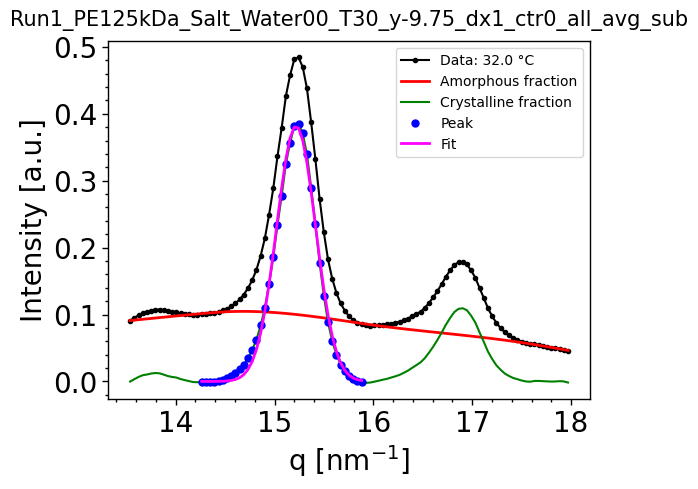

2
Processing file: Run1_PE125kDa_Salt_Water00_T40_y-9.75_dx1_ctr1_all_avg_sub.dat
Percentage crystallinity: 42.39 ± 0.18 %
Figure saved as: /Users/akmaurya/Library/CloudStorage/OneDrive-Stanford/Data_01/Autoxidation_2023/Autoxidation_Water_Part2/OneD_integrated_WAXS_01/Analysis/Figures/Run1_PE125kDa_Salt_Water00_T40_y_fit.png


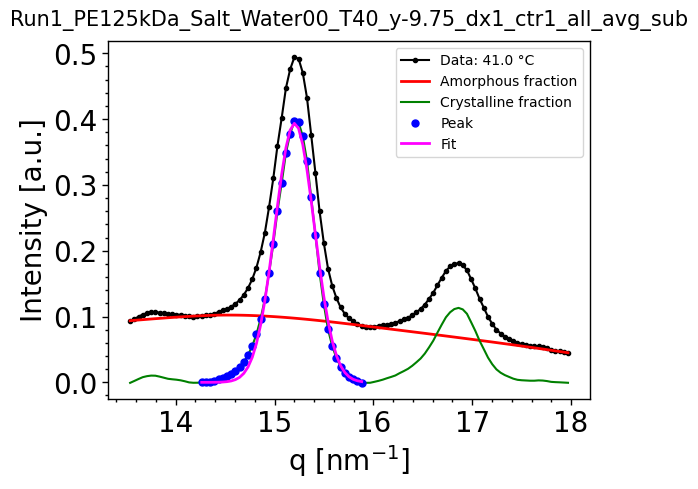

3
Processing file: Run1_PE125kDa_Salt_Water00_T50_y-9.75_dx1_ctr2_all_avg_sub.dat
Percentage crystallinity: 43.18 ± 0.20 %
Figure saved as: /Users/akmaurya/Library/CloudStorage/OneDrive-Stanford/Data_01/Autoxidation_2023/Autoxidation_Water_Part2/OneD_integrated_WAXS_01/Analysis/Figures/Run1_PE125kDa_Salt_Water00_T50_y_fit.png


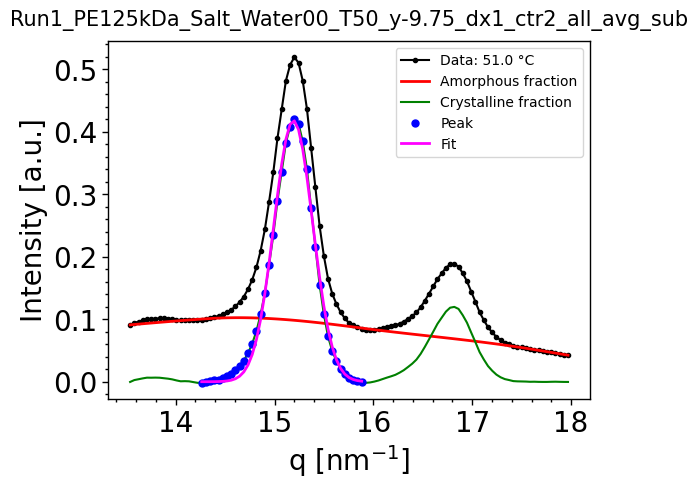

4
Processing file: Run1_PE125kDa_Salt_Water00_T60_y-9.75_dx1_ctr3_all_avg_sub.dat
Percentage crystallinity: 46.70 ± 0.22 %
Figure saved as: /Users/akmaurya/Library/CloudStorage/OneDrive-Stanford/Data_01/Autoxidation_2023/Autoxidation_Water_Part2/OneD_integrated_WAXS_01/Analysis/Figures/Run1_PE125kDa_Salt_Water00_T60_y_fit.png


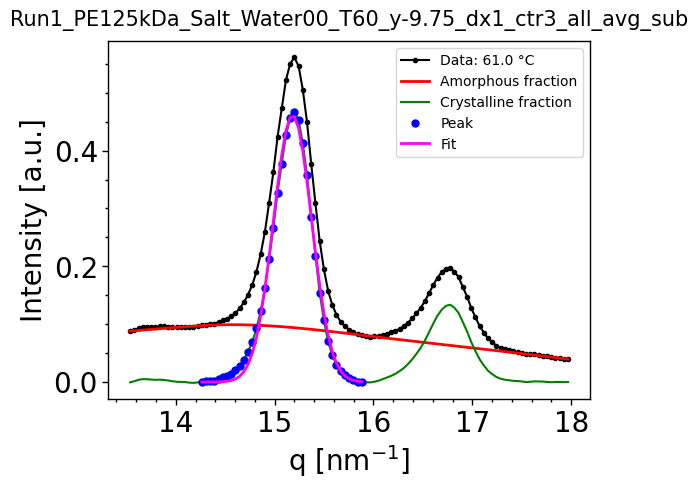

5
Processing file: Run1_PE125kDa_Salt_Water00_T70_y-9.75_dx1_ctr4_all_avg_sub.dat
Percentage crystallinity: 49.60 ± 0.24 %
Figure saved as: /Users/akmaurya/Library/CloudStorage/OneDrive-Stanford/Data_01/Autoxidation_2023/Autoxidation_Water_Part2/OneD_integrated_WAXS_01/Analysis/Figures/Run1_PE125kDa_Salt_Water00_T70_y_fit.png


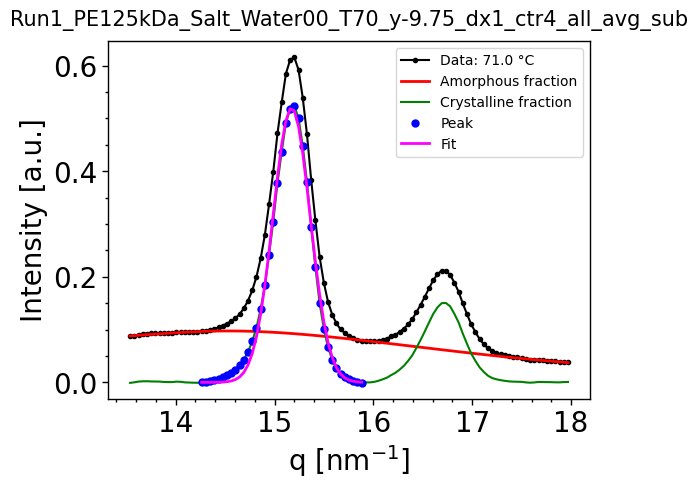

6
Processing file: Run1_PE125kDa_Salt_Water00_T80_y-9.75_dx1_ctr5_all_avg_sub.dat
Percentage crystallinity: 52.04 ± 0.27 %
Figure saved as: /Users/akmaurya/Library/CloudStorage/OneDrive-Stanford/Data_01/Autoxidation_2023/Autoxidation_Water_Part2/OneD_integrated_WAXS_01/Analysis/Figures/Run1_PE125kDa_Salt_Water00_T80_y_fit.png


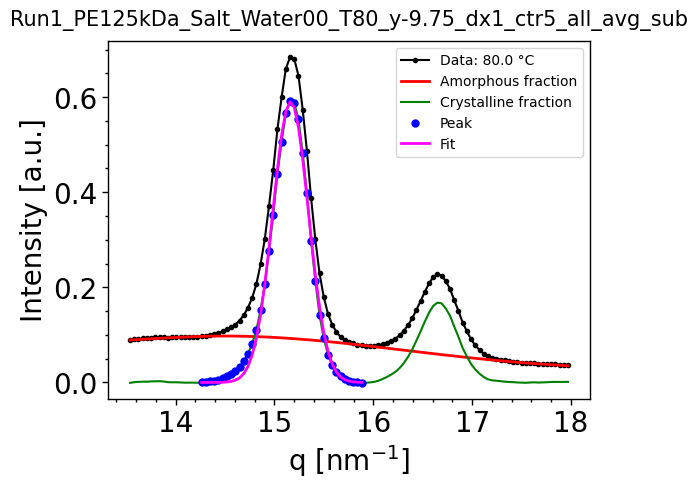

7
Processing file: Run1_PE125kDa_Salt_Water00_T90_y-9.75_dx1_ctr6_all_avg_sub.dat
Percentage crystallinity: 53.25 ± 0.29 %
Figure saved as: /Users/akmaurya/Library/CloudStorage/OneDrive-Stanford/Data_01/Autoxidation_2023/Autoxidation_Water_Part2/OneD_integrated_WAXS_01/Analysis/Figures/Run1_PE125kDa_Salt_Water00_T90_y_fit.png


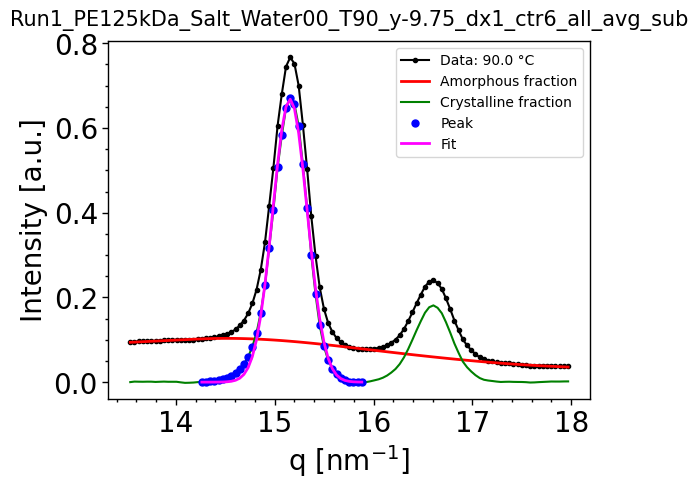

8
Processing file: Run1_PE125kDa_Salt_Water00_T100_y-9.75_dx1_ctr7_all_avg_sub.dat
Percentage crystallinity: 53.28 ± 0.30 %
Figure saved as: /Users/akmaurya/Library/CloudStorage/OneDrive-Stanford/Data_01/Autoxidation_2023/Autoxidation_Water_Part2/OneD_integrated_WAXS_01/Analysis/Figures/Run1_PE125kDa_Salt_Water00_T100_y_fit.png


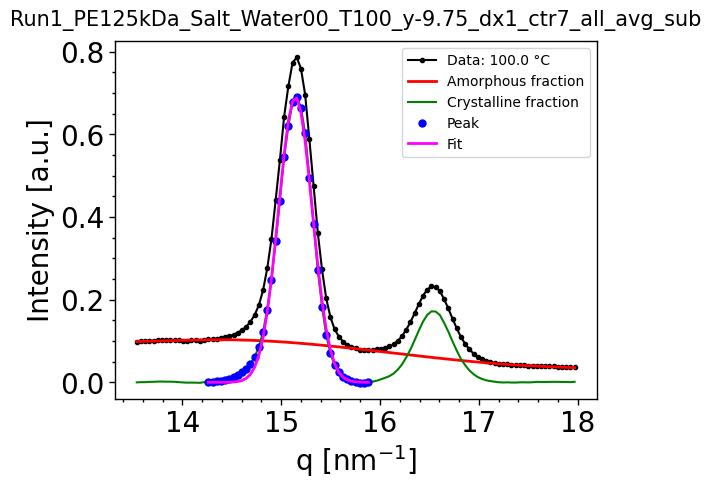

9
Processing file: Run1_PE125kDa_Salt_Water00_T110_y-9.75_dx1_ctr8_all_avg_sub.dat
Percentage crystallinity: 51.65 ± 0.29 %
Figure saved as: /Users/akmaurya/Library/CloudStorage/OneDrive-Stanford/Data_01/Autoxidation_2023/Autoxidation_Water_Part2/OneD_integrated_WAXS_01/Analysis/Figures/Run1_PE125kDa_Salt_Water00_T110_y_fit.png


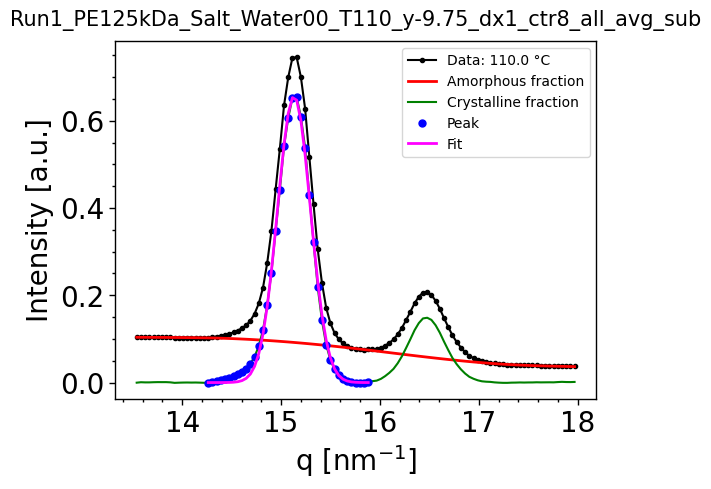

10
Processing file: Run1_PE125kDa_Salt_Water00_T120_y-9.75_dx1_ctr9_all_avg_sub.dat
Percentage crystallinity: 44.38 ± 0.25 %
Figure saved as: /Users/akmaurya/Library/CloudStorage/OneDrive-Stanford/Data_01/Autoxidation_2023/Autoxidation_Water_Part2/OneD_integrated_WAXS_01/Analysis/Figures/Run1_PE125kDa_Salt_Water00_T120_y_fit.png


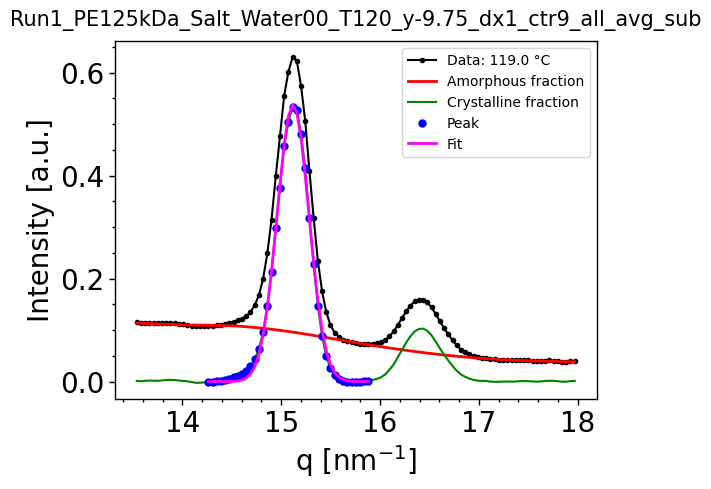

11
Processing file: Run1_PE125kDa_Salt_Water00_T130_y-9.75_dx1_ctr10_all_avg_sub.dat
Percentage crystallinity: 1.52 ± 0.09 %
Figure saved as: /Users/akmaurya/Library/CloudStorage/OneDrive-Stanford/Data_01/Autoxidation_2023/Autoxidation_Water_Part2/OneD_integrated_WAXS_01/Analysis/Figures/Run1_PE125kDa_Salt_Water00_T130_y-_fit.png


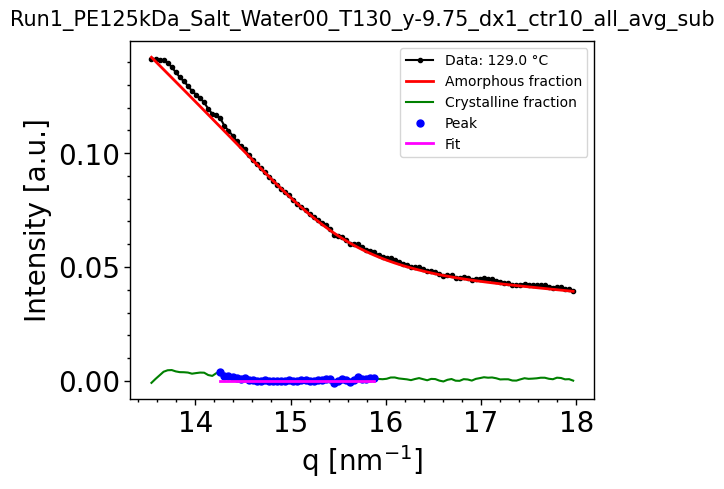

12
Processing file: Run1_PE125kDa_Salt_Water00_T140_y-9.75_dx1_ctr11_all_avg_sub.dat
Percentage crystallinity: 0.81 ± 0.09 %
Figure saved as: /Users/akmaurya/Library/CloudStorage/OneDrive-Stanford/Data_01/Autoxidation_2023/Autoxidation_Water_Part2/OneD_integrated_WAXS_01/Analysis/Figures/Run1_PE125kDa_Salt_Water00_T140_y-_fit.png


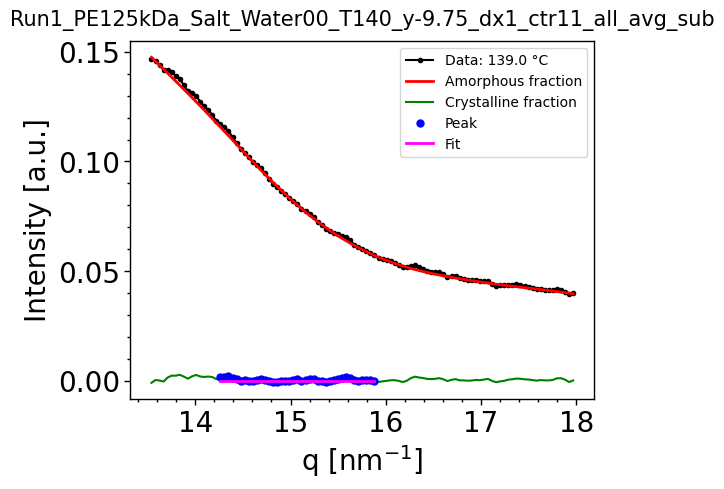

13
Processing file: Run1_PE125kDa_Salt_Water00_T150_y-9.75_dx1_ctr12_all_avg_sub.dat
Percentage crystallinity: 1.30 ± 0.09 %
Figure saved as: /Users/akmaurya/Library/CloudStorage/OneDrive-Stanford/Data_01/Autoxidation_2023/Autoxidation_Water_Part2/OneD_integrated_WAXS_01/Analysis/Figures/Run1_PE125kDa_Salt_Water00_T150_y-_fit.png


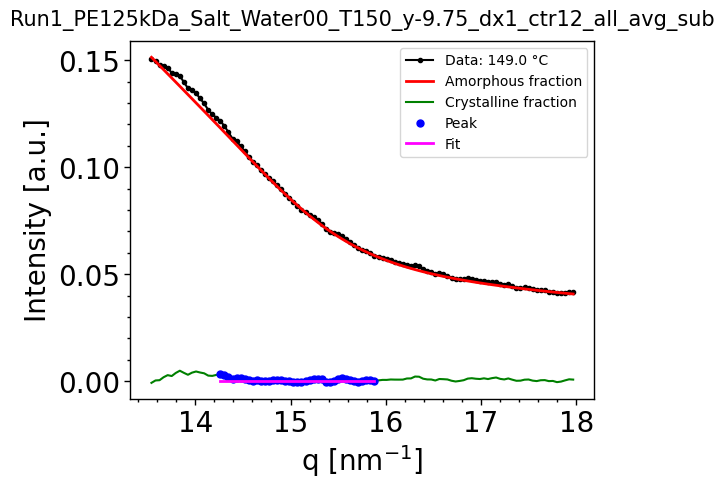

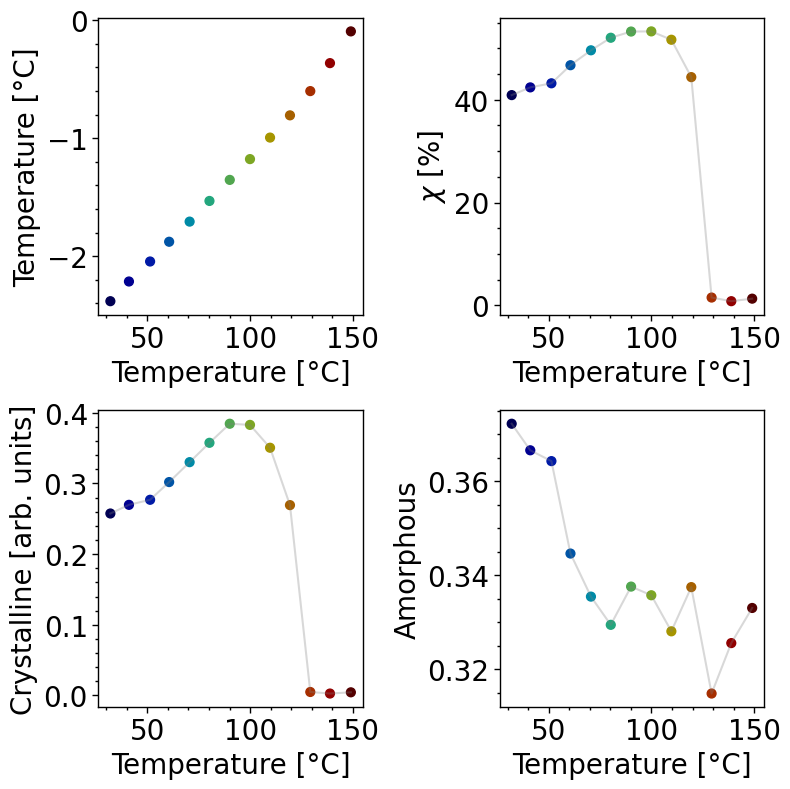

/var/folders/0q/m0d3p44n2cb5dg956r2m2f782yh1mf/T/ipykernel_29208/2438528513.py:230: RuntimeWarning: divide by zero encountered in divide
  size = 0.9 * (1.0 / np.array(fwhm_list)) * 2 * np.pi


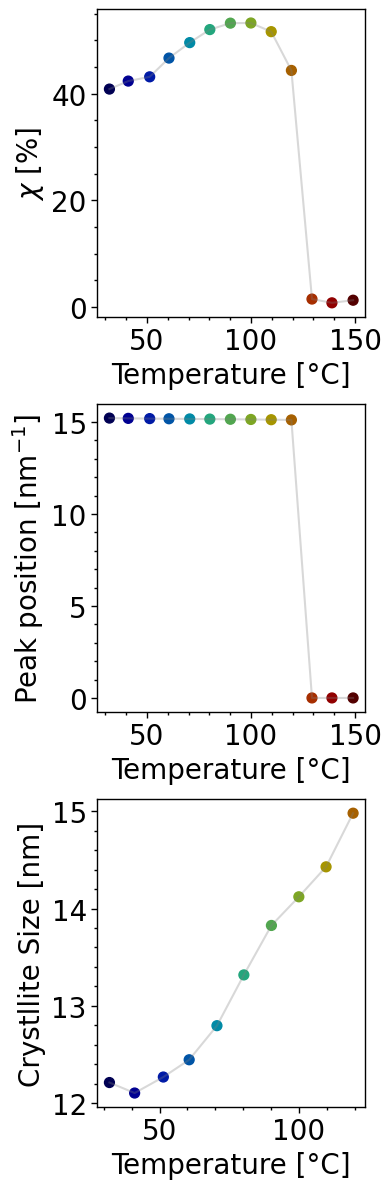

In [32]:

keyword="Run1_PE125kDa_Salt_Water00_T"


darker_colors = darken_colors(num_files_to_plot, darker_factor=0.65)
# Call the function with your desired arguments
Run1_PE_water00 = process_WAXS_data(WAXS_sub_files, keyword, num_files_to_plot, start_index, num_ave_files, min_q_value, max_q_value, qmin_peak, qmax_peak, fit_function, peak_threshold, smmoth_window_size, offset_factor, lam, porder, itermax, save_fitted_results,
                      darker_colors, fonts=20, xvar_plot=None)

#print (data_PE_water50.keys())


# Run2

0 Run2_PE125kDa_Salt_Water50_T30_y-9.59_dx1_ctr0_all_avg_sub.dat
1 Run2_PE125kDa_Salt_Water50_T40_y-9.59_dx1_ctr1_all_avg_sub.dat
2 Run2_PE125kDa_Salt_Water50_T50_y-9.59_dx1_ctr2_all_avg_sub.dat
3 Run2_PE125kDa_Salt_Water50_T60_y-9.59_dx1_ctr3_all_avg_sub.dat
4 Run2_PE125kDa_Salt_Water50_T70_y-9.59_dx1_ctr4_all_avg_sub.dat
5 Run2_PE125kDa_Salt_Water50_T80_y-9.59_dx1_ctr5_all_avg_sub.dat
6 Run2_PE125kDa_Salt_Water50_T90_y-9.59_dx1_ctr6_all_avg_sub.dat
7 Run2_PE125kDa_Salt_Water50_T100_y-9.59_dx1_ctr7_all_avg_sub.dat
8 Run2_PE125kDa_Salt_Water50_T110_y-9.59_dx1_ctr8_all_avg_sub.dat
9 Run2_PE125kDa_Salt_Water50_T120_y-9.59_dx1_ctr9_all_avg_sub.dat
10 Run2_PE125kDa_Salt_Water50_T130_y-9.59_dx1_ctr10_all_avg_sub.dat
11 Run2_PE125kDa_Salt_Water50_T140_y-9.59_dx1_ctr11_all_avg_sub.dat
12 Run2_PE125kDa_Salt_Water50_T150_y-9.59_dx1_ctr12_all_avg_sub.dat
1
Processing file: Run2_PE125kDa_Salt_Water50_T30_y-9.59_dx1_ctr0_all_avg_sub.dat
Percentage crystallinity: 36.44 ± 0.17 %
Figure saved as: /Us

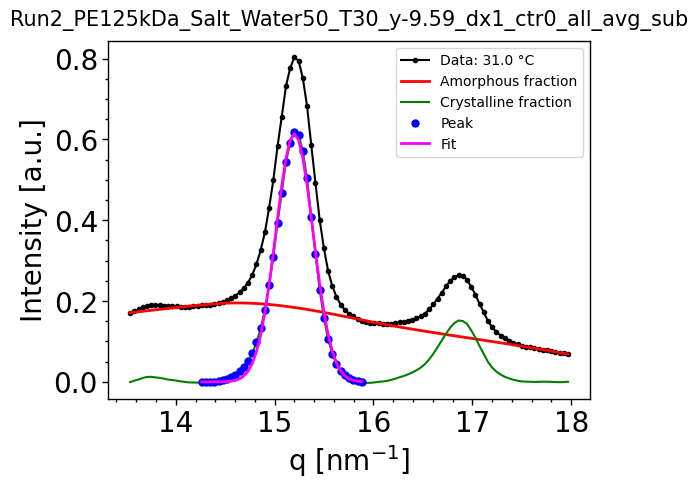

2
Processing file: Run2_PE125kDa_Salt_Water50_T40_y-9.59_dx1_ctr1_all_avg_sub.dat
Percentage crystallinity: 36.14 ± 0.17 %
Figure saved as: /Users/akmaurya/Library/CloudStorage/OneDrive-Stanford/Data_01/Autoxidation_2023/Autoxidation_Water_Part2/OneD_integrated_WAXS_01/Analysis/Figures/Run2_PE125kDa_Salt_Water50_T40_y_fit.png


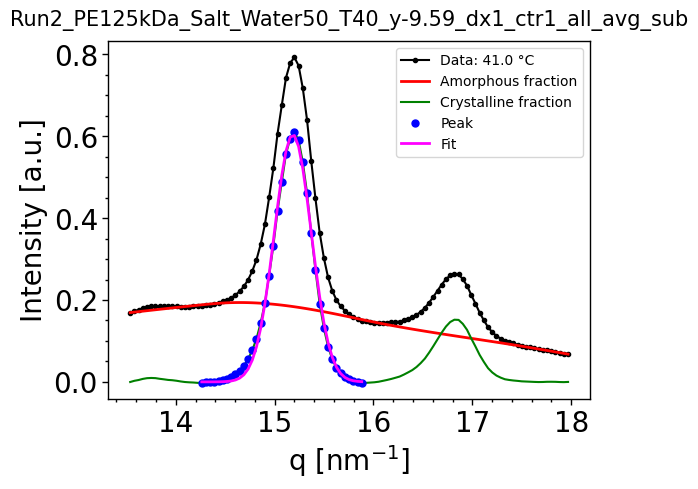

3
Processing file: Run2_PE125kDa_Salt_Water50_T50_y-9.59_dx1_ctr2_all_avg_sub.dat
Percentage crystallinity: 36.28 ± 0.17 %
Figure saved as: /Users/akmaurya/Library/CloudStorage/OneDrive-Stanford/Data_01/Autoxidation_2023/Autoxidation_Water_Part2/OneD_integrated_WAXS_01/Analysis/Figures/Run2_PE125kDa_Salt_Water50_T50_y_fit.png


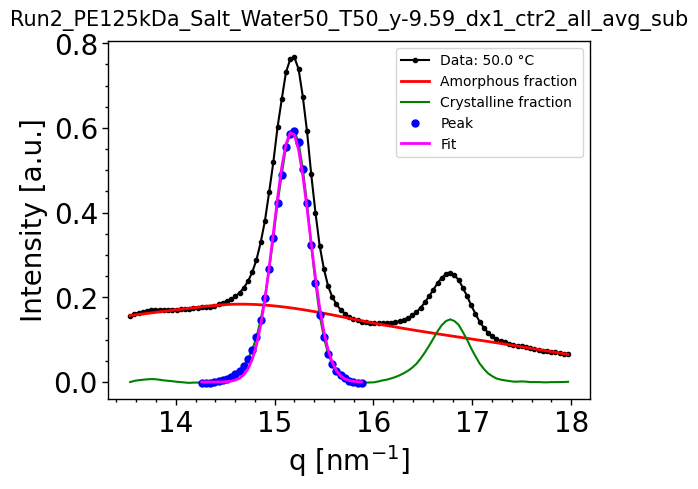

4
Processing file: Run2_PE125kDa_Salt_Water50_T60_y-9.59_dx1_ctr3_all_avg_sub.dat
Percentage crystallinity: 37.98 ± 0.18 %
Figure saved as: /Users/akmaurya/Library/CloudStorage/OneDrive-Stanford/Data_01/Autoxidation_2023/Autoxidation_Water_Part2/OneD_integrated_WAXS_01/Analysis/Figures/Run2_PE125kDa_Salt_Water50_T60_y_fit.png


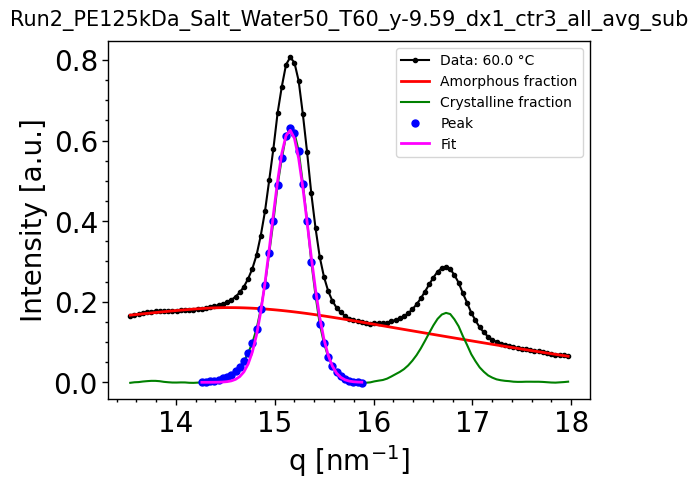

5
Processing file: Run2_PE125kDa_Salt_Water50_T70_y-9.59_dx1_ctr4_all_avg_sub.dat
Percentage crystallinity: 38.53 ± 0.19 %
Figure saved as: /Users/akmaurya/Library/CloudStorage/OneDrive-Stanford/Data_01/Autoxidation_2023/Autoxidation_Water_Part2/OneD_integrated_WAXS_01/Analysis/Figures/Run2_PE125kDa_Salt_Water50_T70_y_fit.png


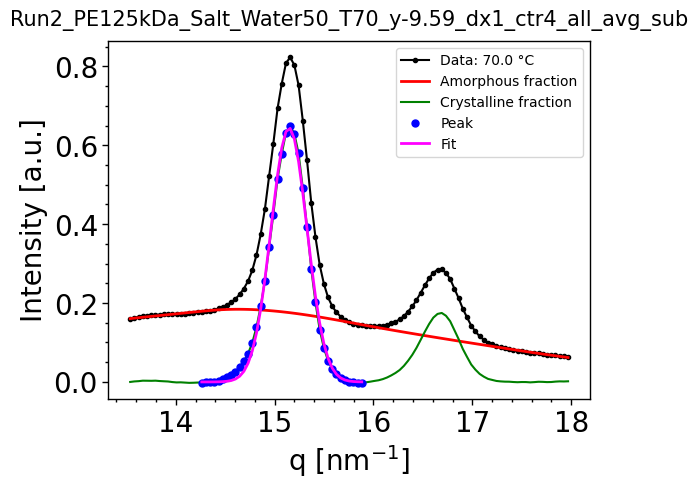

6
Processing file: Run2_PE125kDa_Salt_Water50_T80_y-9.59_dx1_ctr5_all_avg_sub.dat
Percentage crystallinity: 39.27 ± 0.19 %
Figure saved as: /Users/akmaurya/Library/CloudStorage/OneDrive-Stanford/Data_01/Autoxidation_2023/Autoxidation_Water_Part2/OneD_integrated_WAXS_01/Analysis/Figures/Run2_PE125kDa_Salt_Water50_T80_y_fit.png


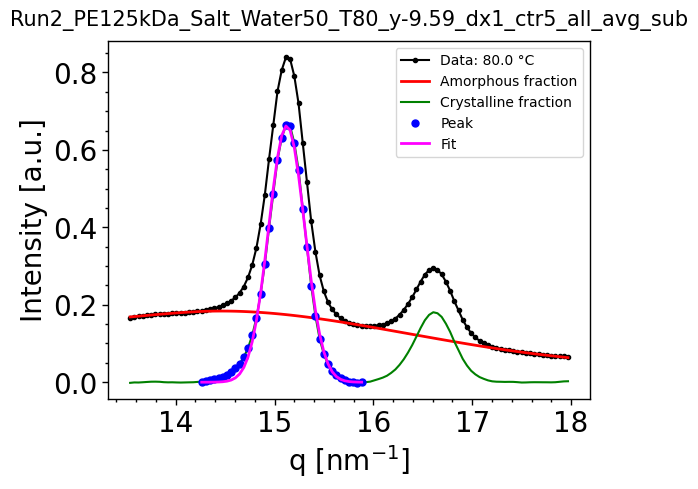

7
Processing file: Run2_PE125kDa_Salt_Water50_T90_y-9.59_dx1_ctr6_all_avg_sub.dat
Percentage crystallinity: 38.73 ± 0.19 %
Figure saved as: /Users/akmaurya/Library/CloudStorage/OneDrive-Stanford/Data_01/Autoxidation_2023/Autoxidation_Water_Part2/OneD_integrated_WAXS_01/Analysis/Figures/Run2_PE125kDa_Salt_Water50_T90_y_fit.png


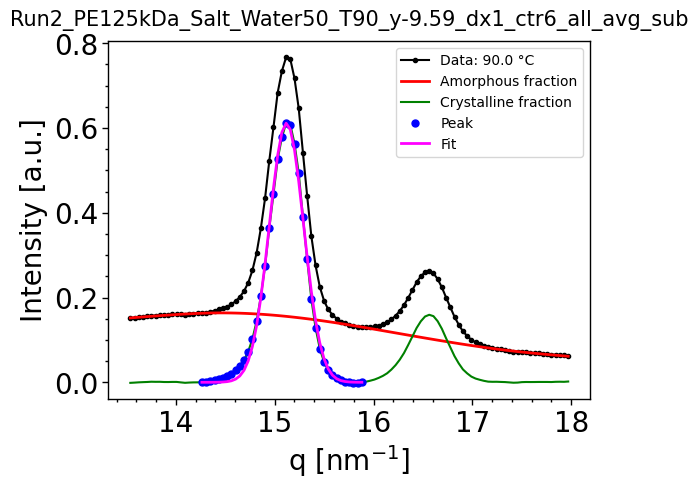

8
Processing file: Run2_PE125kDa_Salt_Water50_T100_y-9.59_dx1_ctr7_all_avg_sub.dat
Percentage crystallinity: 37.25 ± 0.18 %
Figure saved as: /Users/akmaurya/Library/CloudStorage/OneDrive-Stanford/Data_01/Autoxidation_2023/Autoxidation_Water_Part2/OneD_integrated_WAXS_01/Analysis/Figures/Run2_PE125kDa_Salt_Water50_T100_y_fit.png


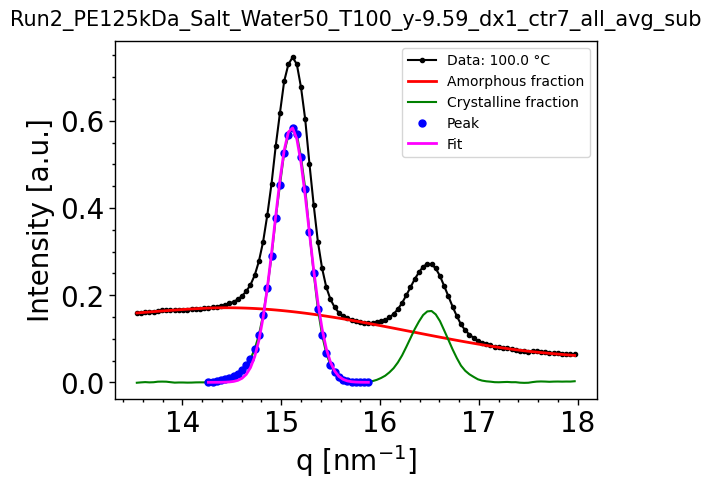

9
Processing file: Run2_PE125kDa_Salt_Water50_T110_y-9.59_dx1_ctr8_all_avg_sub.dat
Percentage crystallinity: 36.88 ± 0.20 %
Figure saved as: /Users/akmaurya/Library/CloudStorage/OneDrive-Stanford/Data_01/Autoxidation_2023/Autoxidation_Water_Part2/OneD_integrated_WAXS_01/Analysis/Figures/Run2_PE125kDa_Salt_Water50_T110_y_fit.png


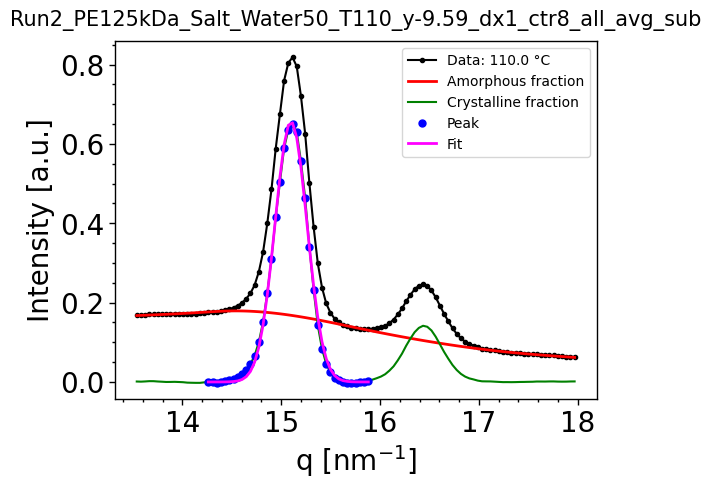

10
Processing file: Run2_PE125kDa_Salt_Water50_T120_y-9.59_dx1_ctr9_all_avg_sub.dat
Percentage crystallinity: 30.88 ± 0.16 %
Figure saved as: /Users/akmaurya/Library/CloudStorage/OneDrive-Stanford/Data_01/Autoxidation_2023/Autoxidation_Water_Part2/OneD_integrated_WAXS_01/Analysis/Figures/Run2_PE125kDa_Salt_Water50_T120_y_fit.png


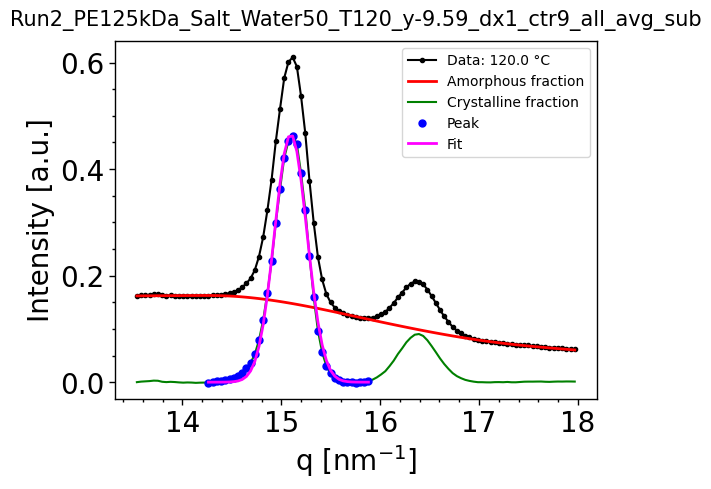

11
Processing file: Run2_PE125kDa_Salt_Water50_T130_y-9.59_dx1_ctr10_all_avg_sub.dat
Percentage crystallinity: 3.29 ± 0.08 %
Figure saved as: /Users/akmaurya/Library/CloudStorage/OneDrive-Stanford/Data_01/Autoxidation_2023/Autoxidation_Water_Part2/OneD_integrated_WAXS_01/Analysis/Figures/Run2_PE125kDa_Salt_Water50_T130_y-_fit.png


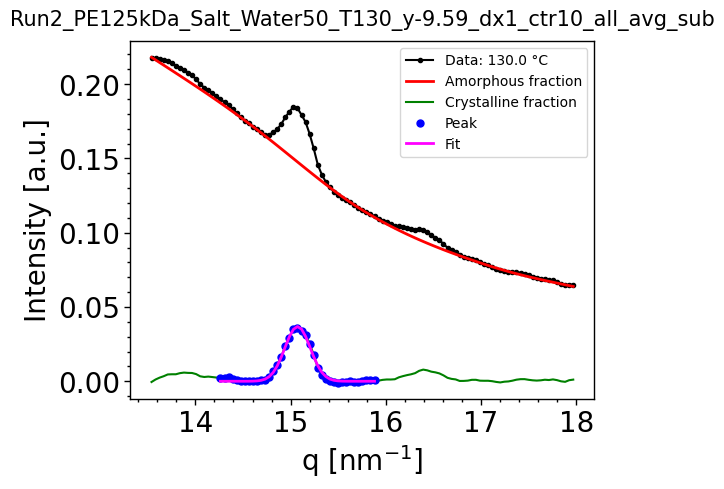

12
Processing file: Run2_PE125kDa_Salt_Water50_T140_y-9.59_dx1_ctr11_all_avg_sub.dat
Percentage crystallinity: 0.36 ± 0.08 %
Figure saved as: /Users/akmaurya/Library/CloudStorage/OneDrive-Stanford/Data_01/Autoxidation_2023/Autoxidation_Water_Part2/OneD_integrated_WAXS_01/Analysis/Figures/Run2_PE125kDa_Salt_Water50_T140_y-_fit.png


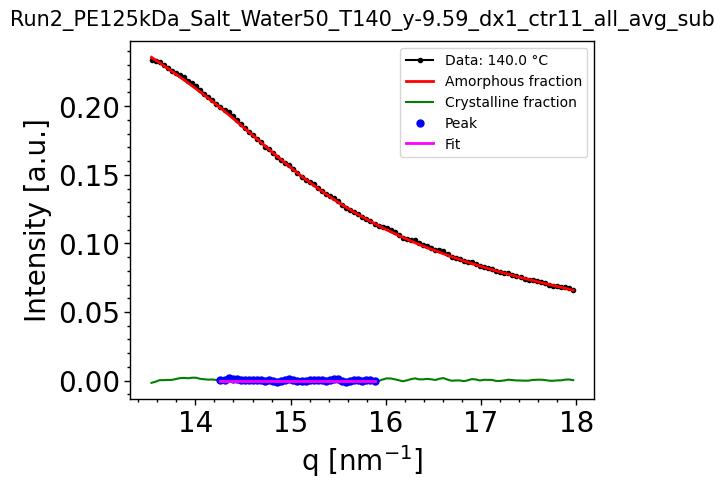

13
Processing file: Run2_PE125kDa_Salt_Water50_T150_y-9.59_dx1_ctr12_all_avg_sub.dat
Percentage crystallinity: 0.46 ± 0.08 %
Figure saved as: /Users/akmaurya/Library/CloudStorage/OneDrive-Stanford/Data_01/Autoxidation_2023/Autoxidation_Water_Part2/OneD_integrated_WAXS_01/Analysis/Figures/Run2_PE125kDa_Salt_Water50_T150_y-_fit.png


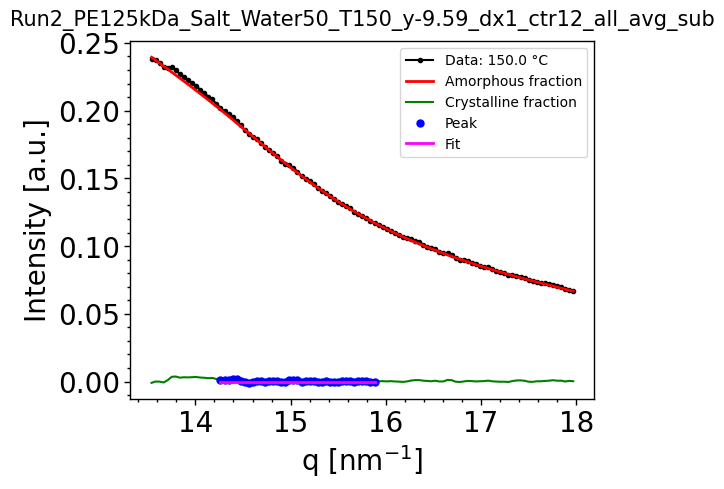

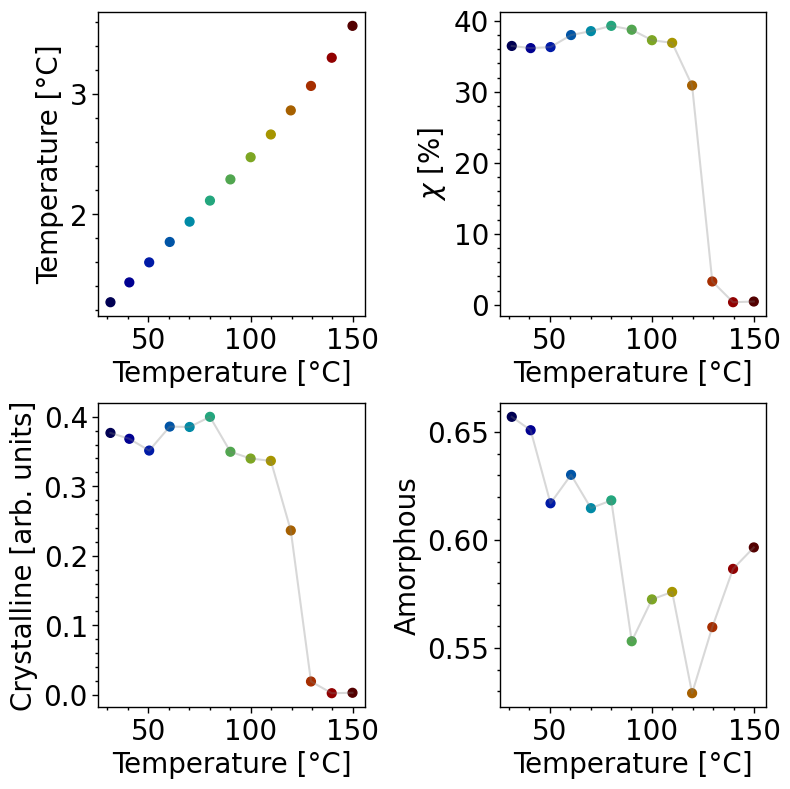

/var/folders/0q/m0d3p44n2cb5dg956r2m2f782yh1mf/T/ipykernel_29208/2438528513.py:230: RuntimeWarning: divide by zero encountered in divide
  size = 0.9 * (1.0 / np.array(fwhm_list)) * 2 * np.pi


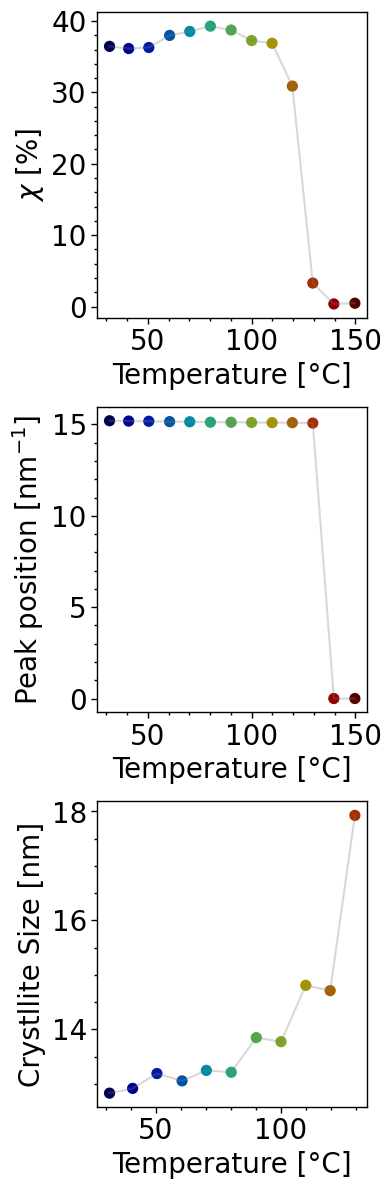

In [33]:

keyword="Run2_PE125kDa_Salt_Water50_T"

darker_colors = darken_colors(num_files_to_plot, darker_factor=0.65)
# Call the function with your desired arguments
Run2_PE_water50=process_WAXS_data(WAXS_sub_files, keyword, num_files_to_plot, start_index, num_ave_files, min_q_value, max_q_value, qmin_peak, qmax_peak, fit_function, peak_threshold, smmoth_window_size, offset_factor, lam, porder, itermax, save_fitted_results,
                      darker_colors, fonts=20, xvar_plot=None)


# Run3

0 Run3_PE125kDa_Salt_Water100_T30_y-9.75_dx1_ctr0_all_avg_sub.dat
1 Run3_PE125kDa_Salt_Water100_T40_y-9.75_dx1_ctr1_all_avg_sub.dat
2 Run3_PE125kDa_Salt_Water100_T50_y-9.75_dx1_ctr2_all_avg_sub.dat
3 Run3_PE125kDa_Salt_Water100_T60_y-9.75_dx1_ctr3_all_avg_sub.dat
4 Run3_PE125kDa_Salt_Water100_T70_y-9.75_dx1_ctr4_all_avg_sub.dat
5 Run3_PE125kDa_Salt_Water100_T80_y-9.75_dx1_ctr5_all_avg_sub.dat
6 Run3_PE125kDa_Salt_Water100_T90_y-9.75_dx1_ctr6_all_avg_sub.dat
7 Run3_PE125kDa_Salt_Water100_T100_y-9.75_dx1_ctr7_all_avg_sub.dat
8 Run3_PE125kDa_Salt_Water100_T110_y-9.75_dx1_ctr8_all_avg_sub.dat
9 Run3_PE125kDa_Salt_Water100_T120_y-9.75_dx1_ctr9_all_avg_sub.dat
10 Run3_PE125kDa_Salt_Water100_T130_y-9.75_dx1_ctr10_all_avg_sub.dat
11 Run3_PE125kDa_Salt_Water100_T140_y-9.75_dx1_ctr11_all_avg_sub.dat
12 Run3_PE125kDa_Salt_Water100_T150_y-9.75_dx1_ctr12_all_avg_sub.dat
1
Processing file: Run3_PE125kDa_Salt_Water100_T30_y-9.75_dx1_ctr0_all_avg_sub.dat
Percentage crystallinity: 29.30 ± 0.13 %
Figure

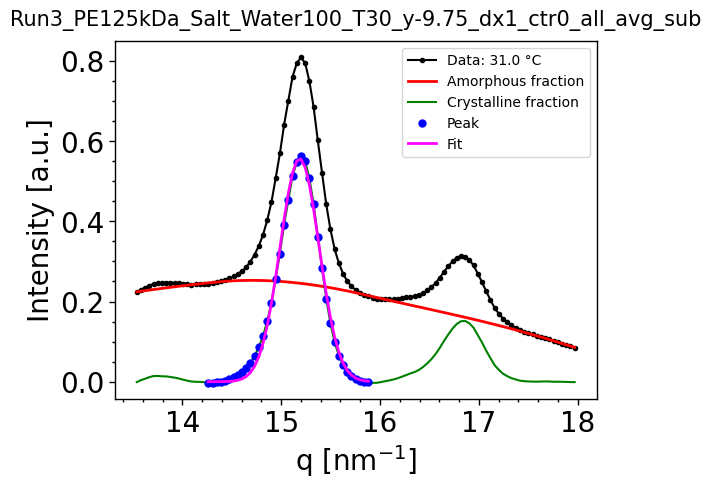

2
Processing file: Run3_PE125kDa_Salt_Water100_T40_y-9.75_dx1_ctr1_all_avg_sub.dat
Percentage crystallinity: 31.57 ± 0.14 %
Figure saved as: /Users/akmaurya/Library/CloudStorage/OneDrive-Stanford/Data_01/Autoxidation_2023/Autoxidation_Water_Part2/OneD_integrated_WAXS_01/Analysis/Figures/Run3_PE125kDa_Salt_Water100_T40_y_fit.png


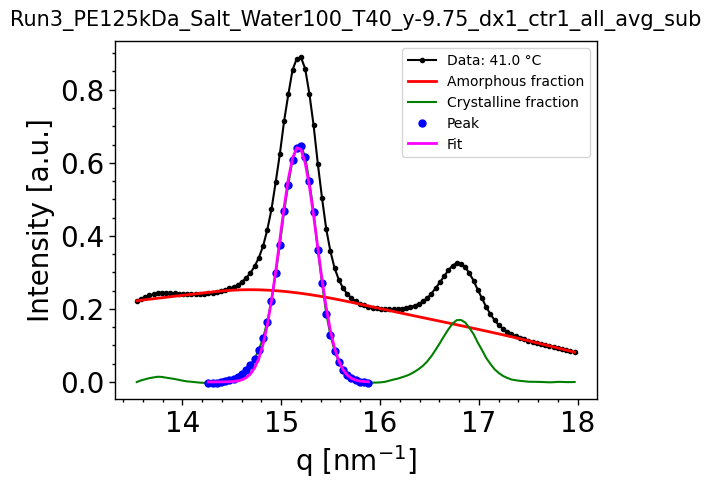

3
Processing file: Run3_PE125kDa_Salt_Water100_T50_y-9.75_dx1_ctr2_all_avg_sub.dat
Percentage crystallinity: 32.49 ± 0.15 %
Figure saved as: /Users/akmaurya/Library/CloudStorage/OneDrive-Stanford/Data_01/Autoxidation_2023/Autoxidation_Water_Part2/OneD_integrated_WAXS_01/Analysis/Figures/Run3_PE125kDa_Salt_Water100_T50_y_fit.png


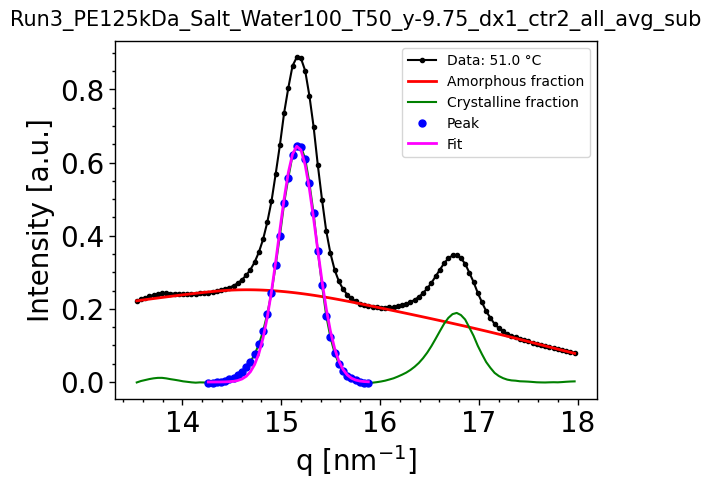

4
Processing file: Run3_PE125kDa_Salt_Water100_T60_y-9.75_dx1_ctr3_all_avg_sub.dat
Percentage crystallinity: 34.32 ± 0.16 %
Figure saved as: /Users/akmaurya/Library/CloudStorage/OneDrive-Stanford/Data_01/Autoxidation_2023/Autoxidation_Water_Part2/OneD_integrated_WAXS_01/Analysis/Figures/Run3_PE125kDa_Salt_Water100_T60_y_fit.png


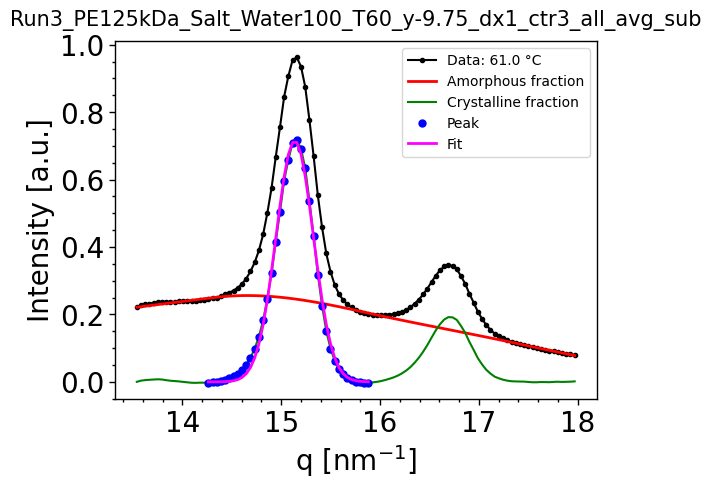

5
Processing file: Run3_PE125kDa_Salt_Water100_T70_y-9.75_dx1_ctr4_all_avg_sub.dat
Percentage crystallinity: 36.57 ± 0.18 %
Figure saved as: /Users/akmaurya/Library/CloudStorage/OneDrive-Stanford/Data_01/Autoxidation_2023/Autoxidation_Water_Part2/OneD_integrated_WAXS_01/Analysis/Figures/Run3_PE125kDa_Salt_Water100_T70_y_fit.png


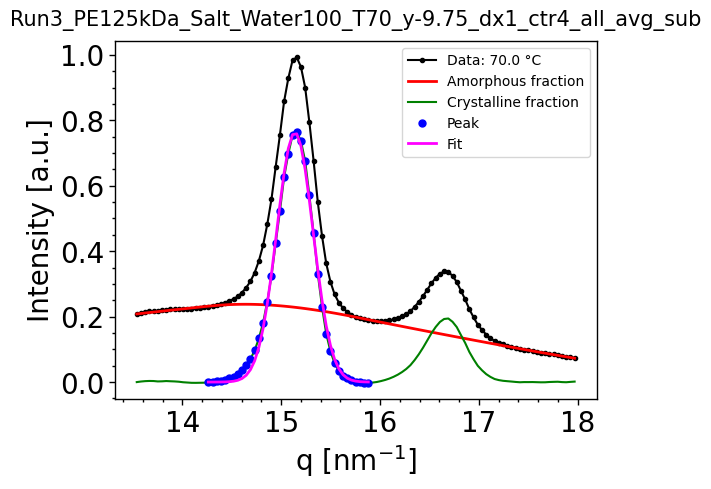

6
Processing file: Run3_PE125kDa_Salt_Water100_T80_y-9.75_dx1_ctr5_all_avg_sub.dat
Percentage crystallinity: 35.61 ± 0.17 %
Figure saved as: /Users/akmaurya/Library/CloudStorage/OneDrive-Stanford/Data_01/Autoxidation_2023/Autoxidation_Water_Part2/OneD_integrated_WAXS_01/Analysis/Figures/Run3_PE125kDa_Salt_Water100_T80_y_fit.png


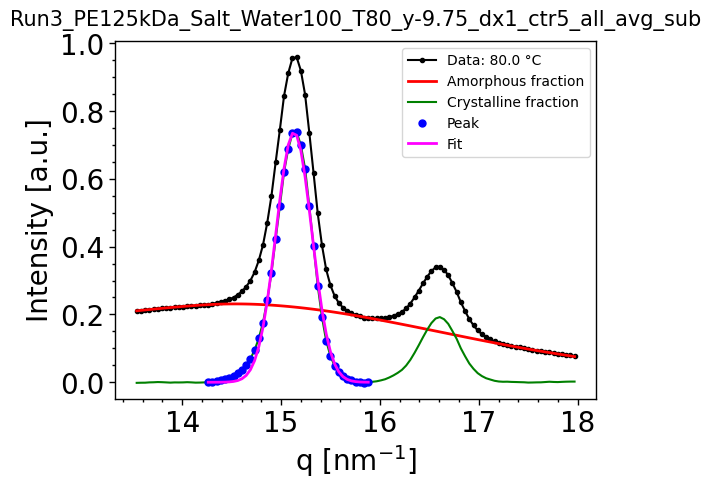

7
Processing file: Run3_PE125kDa_Salt_Water100_T90_y-9.75_dx1_ctr6_all_avg_sub.dat
Percentage crystallinity: 34.19 ± 0.17 %
Figure saved as: /Users/akmaurya/Library/CloudStorage/OneDrive-Stanford/Data_01/Autoxidation_2023/Autoxidation_Water_Part2/OneD_integrated_WAXS_01/Analysis/Figures/Run3_PE125kDa_Salt_Water100_T90_y_fit.png


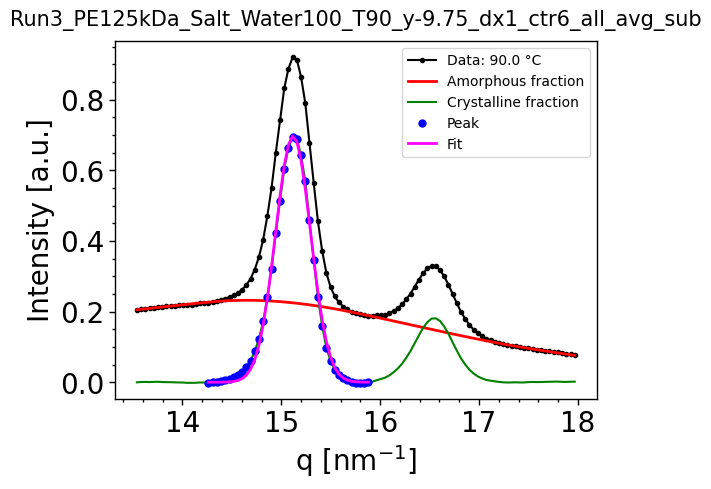

8
Processing file: Run3_PE125kDa_Salt_Water100_T100_y-9.75_dx1_ctr7_all_avg_sub.dat
Percentage crystallinity: 33.18 ± 0.16 %
Figure saved as: /Users/akmaurya/Library/CloudStorage/OneDrive-Stanford/Data_01/Autoxidation_2023/Autoxidation_Water_Part2/OneD_integrated_WAXS_01/Analysis/Figures/Run3_PE125kDa_Salt_Water100_T100_y_fit.png


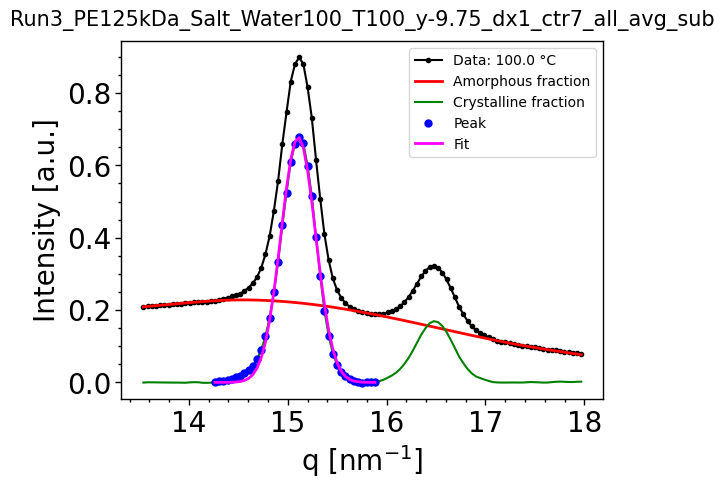

9
Processing file: Run3_PE125kDa_Salt_Water100_T110_y-9.75_dx1_ctr8_all_avg_sub.dat
Percentage crystallinity: 31.66 ± 0.16 %
Figure saved as: /Users/akmaurya/Library/CloudStorage/OneDrive-Stanford/Data_01/Autoxidation_2023/Autoxidation_Water_Part2/OneD_integrated_WAXS_01/Analysis/Figures/Run3_PE125kDa_Salt_Water100_T110_y_fit.png


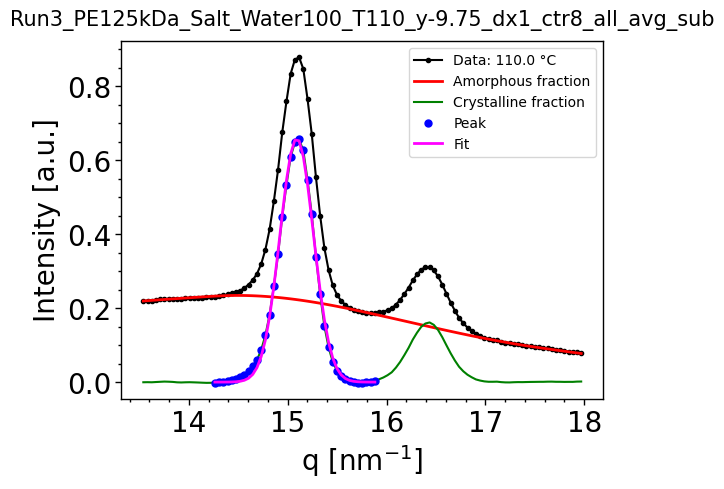

10
Processing file: Run3_PE125kDa_Salt_Water100_T120_y-9.75_dx1_ctr9_all_avg_sub.dat
Percentage crystallinity: 30.20 ± 0.16 %
Figure saved as: /Users/akmaurya/Library/CloudStorage/OneDrive-Stanford/Data_01/Autoxidation_2023/Autoxidation_Water_Part2/OneD_integrated_WAXS_01/Analysis/Figures/Run3_PE125kDa_Salt_Water100_T120_y_fit.png


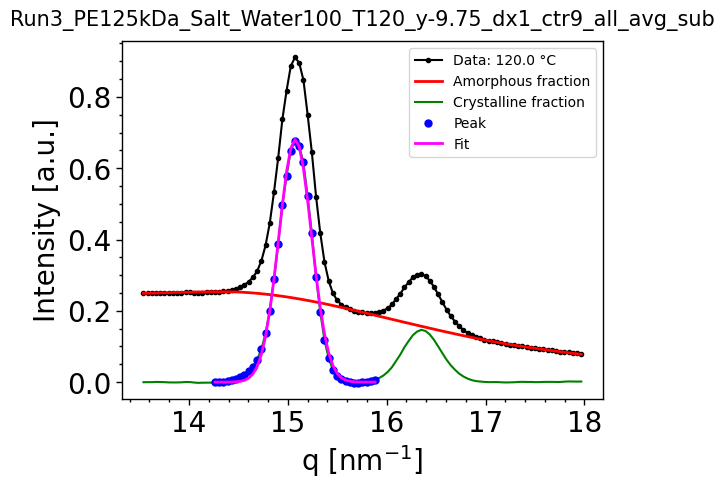

11
Processing file: Run3_PE125kDa_Salt_Water100_T130_y-9.75_dx1_ctr10_all_avg_sub.dat
Percentage crystallinity: 2.15 ± 0.08 %
Figure saved as: /Users/akmaurya/Library/CloudStorage/OneDrive-Stanford/Data_01/Autoxidation_2023/Autoxidation_Water_Part2/OneD_integrated_WAXS_01/Analysis/Figures/Run3_PE125kDa_Salt_Water100_T130_y-_fit.png


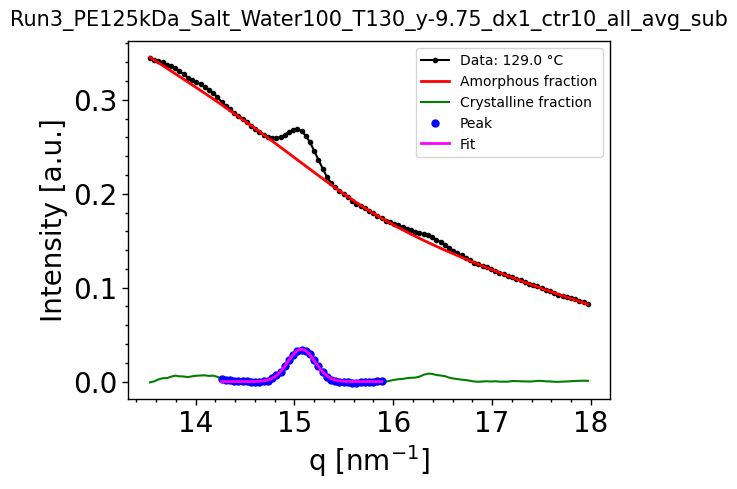

12
Processing file: Run3_PE125kDa_Salt_Water100_T140_y-9.75_dx1_ctr11_all_avg_sub.dat
Percentage crystallinity: 0.42 ± 0.08 %
Figure saved as: /Users/akmaurya/Library/CloudStorage/OneDrive-Stanford/Data_01/Autoxidation_2023/Autoxidation_Water_Part2/OneD_integrated_WAXS_01/Analysis/Figures/Run3_PE125kDa_Salt_Water100_T140_y-_fit.png


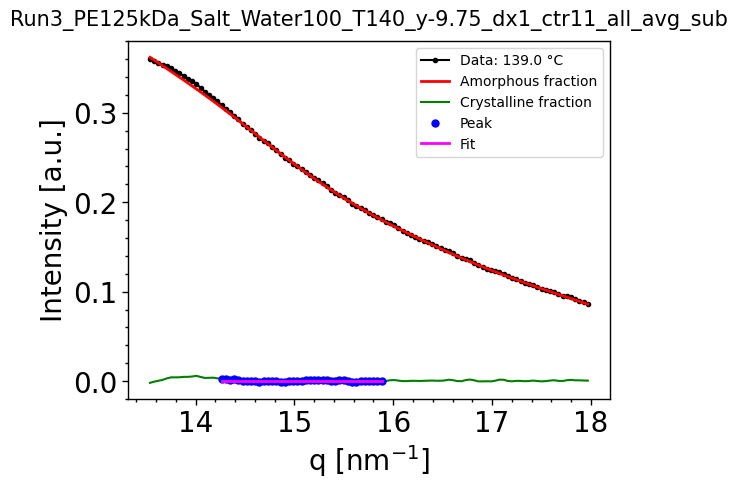

13
Processing file: Run3_PE125kDa_Salt_Water100_T150_y-9.75_dx1_ctr12_all_avg_sub.dat
Percentage crystallinity: 0.57 ± 0.08 %
Figure saved as: /Users/akmaurya/Library/CloudStorage/OneDrive-Stanford/Data_01/Autoxidation_2023/Autoxidation_Water_Part2/OneD_integrated_WAXS_01/Analysis/Figures/Run3_PE125kDa_Salt_Water100_T150_y-_fit.png


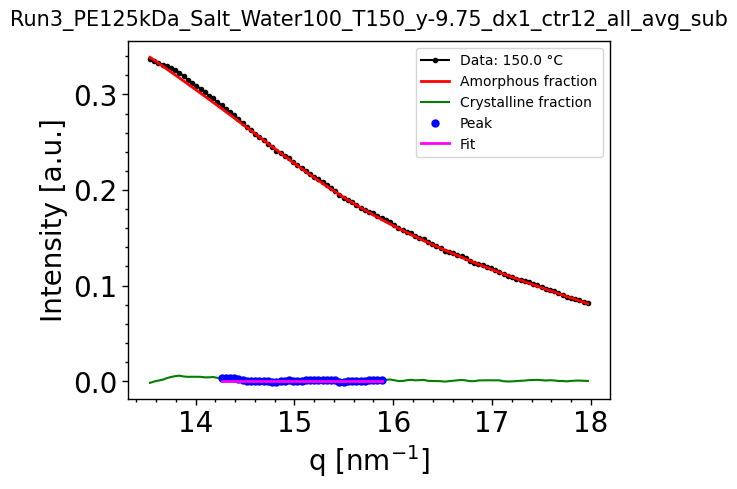

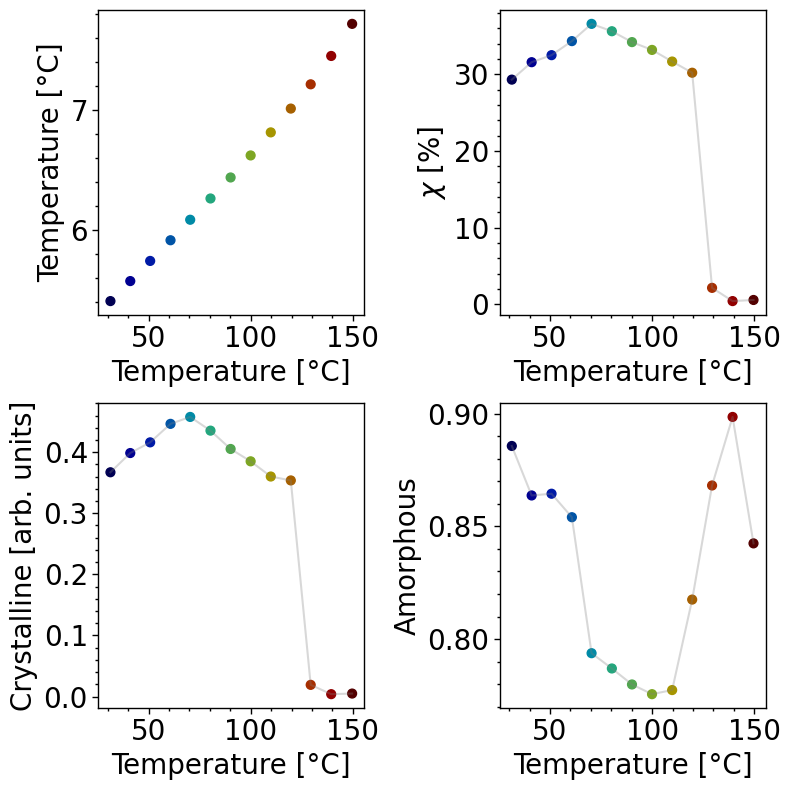

/var/folders/0q/m0d3p44n2cb5dg956r2m2f782yh1mf/T/ipykernel_29208/2438528513.py:230: RuntimeWarning: divide by zero encountered in divide
  size = 0.9 * (1.0 / np.array(fwhm_list)) * 2 * np.pi


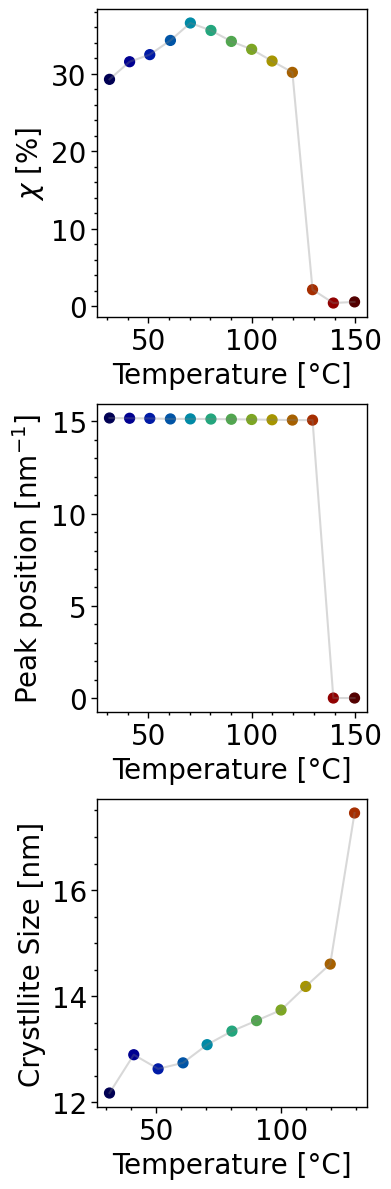

In [34]:

keyword="Run3_PE125kDa_Salt_Water100_T"
# Call the function with your desired arguments
Run3_PE_water100=process_WAXS_data(WAXS_sub_files, keyword, num_files_to_plot, start_index, num_ave_files, min_q_value, max_q_value, qmin_peak, qmax_peak, fit_function, peak_threshold, smmoth_window_size, offset_factor, lam, porder, itermax, save_fitted_results,
                      darker_colors, fonts=20, xvar_plot=None)


# Run4

0 Run4_PE125kDa_T30_y-9.61_dx1_ctr0_all_avg_sub.dat
1 Run4_PE125kDa_T40_y-9.61_dx1_ctr1_all_avg_sub.dat
2 Run4_PE125kDa_T50_y-9.61_dx1_ctr2_all_avg_sub.dat
3 Run4_PE125kDa_T60_y-9.61_dx1_ctr3_all_avg_sub.dat
4 Run4_PE125kDa_T70_y-9.61_dx1_ctr4_all_avg_sub.dat
5 Run4_PE125kDa_T80_y-9.61_dx1_ctr5_all_avg_sub.dat
6 Run4_PE125kDa_T90_y-9.61_dx1_ctr6_all_avg_sub.dat
7 Run4_PE125kDa_T100_y-9.61_dx1_ctr7_all_avg_sub.dat
8 Run4_PE125kDa_T110_y-9.61_dx1_ctr8_all_avg_sub.dat
9 Run4_PE125kDa_T120_y-9.61_dx1_ctr9_all_avg_sub.dat
10 Run4_PE125kDa_T130_y-9.61_dx1_ctr10_all_avg_sub.dat
11 Run4_PE125kDa_T140_y-9.61_dx1_ctr11_all_avg_sub.dat
12 Run4_PE125kDa_T150_y-9.61_dx1_ctr12_all_avg_sub.dat
1
Processing file: Run4_PE125kDa_T30_y-9.61_dx1_ctr0_all_avg_sub.dat
Percentage crystallinity: 52.54 ± 0.27 %
Figure saved as: /Users/akmaurya/Library/CloudStorage/OneDrive-Stanford/Data_01/Autoxidation_2023/Autoxidation_Water_Part2/OneD_integrated_WAXS_01/Analysis/Figures/Run4_PE125kDa_T30_y_fit.png


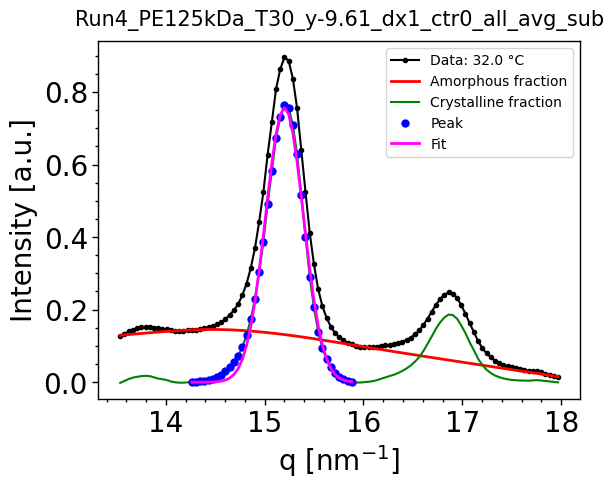

2
Processing file: Run4_PE125kDa_T40_y-9.61_dx1_ctr1_all_avg_sub.dat
Percentage crystallinity: 52.17 ± 0.27 %
Figure saved as: /Users/akmaurya/Library/CloudStorage/OneDrive-Stanford/Data_01/Autoxidation_2023/Autoxidation_Water_Part2/OneD_integrated_WAXS_01/Analysis/Figures/Run4_PE125kDa_T40_y_fit.png


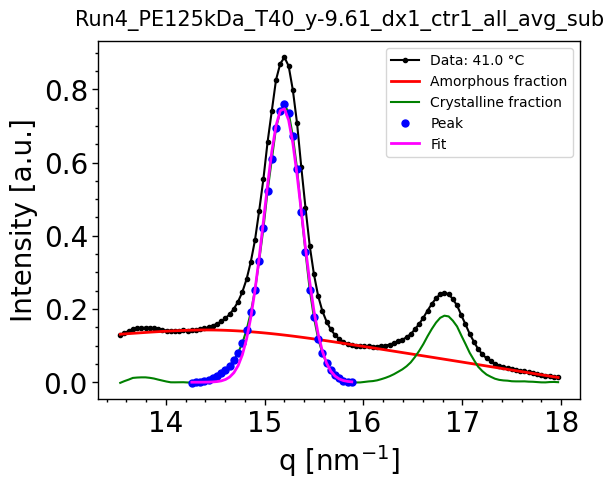

3
Processing file: Run4_PE125kDa_T50_y-9.61_dx1_ctr2_all_avg_sub.dat
Percentage crystallinity: 54.23 ± 0.29 %
Figure saved as: /Users/akmaurya/Library/CloudStorage/OneDrive-Stanford/Data_01/Autoxidation_2023/Autoxidation_Water_Part2/OneD_integrated_WAXS_01/Analysis/Figures/Run4_PE125kDa_T50_y_fit.png


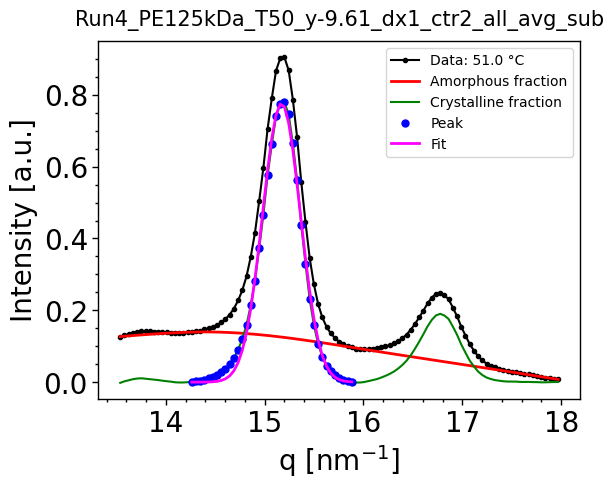

4
Processing file: Run4_PE125kDa_T60_y-9.61_dx1_ctr3_all_avg_sub.dat
Percentage crystallinity: 55.77 ± 0.31 %
Figure saved as: /Users/akmaurya/Library/CloudStorage/OneDrive-Stanford/Data_01/Autoxidation_2023/Autoxidation_Water_Part2/OneD_integrated_WAXS_01/Analysis/Figures/Run4_PE125kDa_T60_y_fit.png


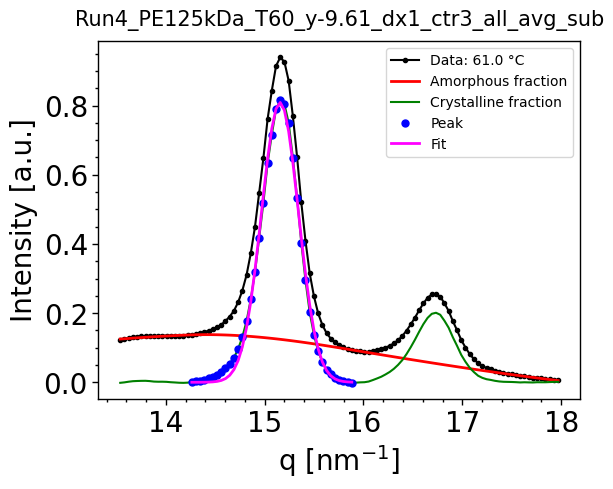

5
Processing file: Run4_PE125kDa_T70_y-9.61_dx1_ctr4_all_avg_sub.dat
Percentage crystallinity: 57.73 ± 0.33 %
Figure saved as: /Users/akmaurya/Library/CloudStorage/OneDrive-Stanford/Data_01/Autoxidation_2023/Autoxidation_Water_Part2/OneD_integrated_WAXS_01/Analysis/Figures/Run4_PE125kDa_T70_y_fit.png


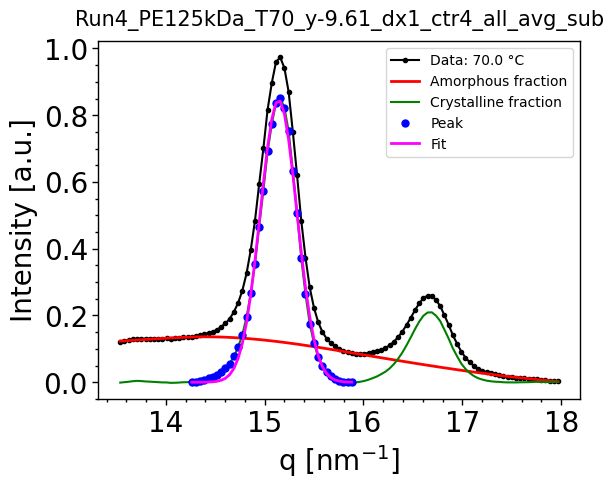

6
Processing file: Run4_PE125kDa_T80_y-9.61_dx1_ctr5_all_avg_sub.dat
Percentage crystallinity: 58.39 ± 0.35 %
Figure saved as: /Users/akmaurya/Library/CloudStorage/OneDrive-Stanford/Data_01/Autoxidation_2023/Autoxidation_Water_Part2/OneD_integrated_WAXS_01/Analysis/Figures/Run4_PE125kDa_T80_y_fit.png


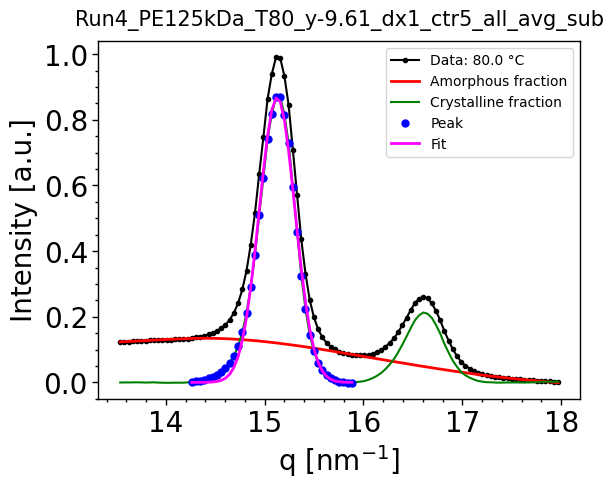

7
Processing file: Run4_PE125kDa_T90_y-9.61_dx1_ctr6_all_avg_sub.dat
Percentage crystallinity: 58.98 ± 0.36 %
Figure saved as: /Users/akmaurya/Library/CloudStorage/OneDrive-Stanford/Data_01/Autoxidation_2023/Autoxidation_Water_Part2/OneD_integrated_WAXS_01/Analysis/Figures/Run4_PE125kDa_T90_y_fit.png


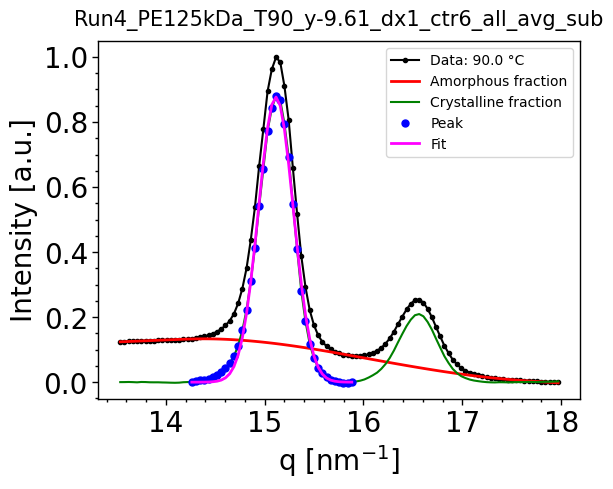

8
Processing file: Run4_PE125kDa_T100_y-9.61_dx1_ctr7_all_avg_sub.dat
Percentage crystallinity: 58.63 ± 0.36 %
Figure saved as: /Users/akmaurya/Library/CloudStorage/OneDrive-Stanford/Data_01/Autoxidation_2023/Autoxidation_Water_Part2/OneD_integrated_WAXS_01/Analysis/Figures/Run4_PE125kDa_T100_y_fit.png


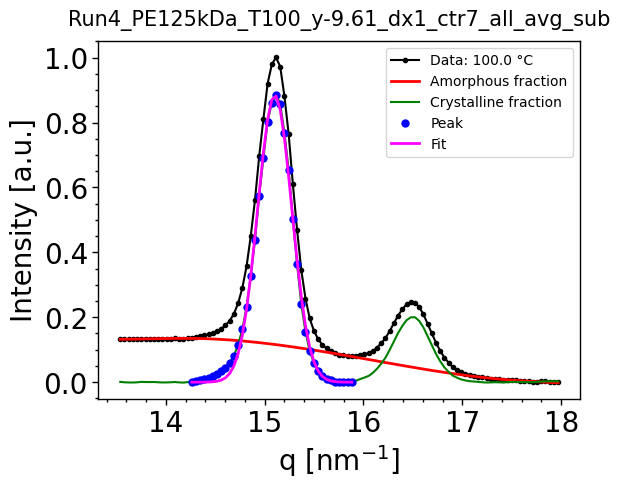

9
Processing file: Run4_PE125kDa_T110_y-9.61_dx1_ctr8_all_avg_sub.dat
Percentage crystallinity: 56.78 ± 0.36 %
Figure saved as: /Users/akmaurya/Library/CloudStorage/OneDrive-Stanford/Data_01/Autoxidation_2023/Autoxidation_Water_Part2/OneD_integrated_WAXS_01/Analysis/Figures/Run4_PE125kDa_T110_y_fit.png


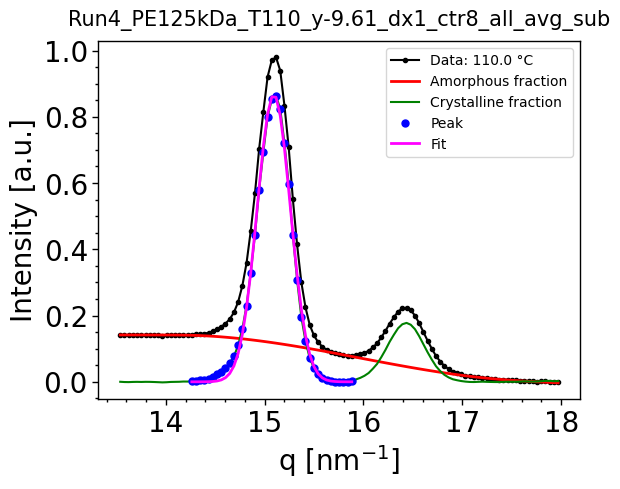

10
Processing file: Run4_PE125kDa_T120_y-9.61_dx1_ctr9_all_avg_sub.dat
Percentage crystallinity: 52.74 ± 0.34 %
Figure saved as: /Users/akmaurya/Library/CloudStorage/OneDrive-Stanford/Data_01/Autoxidation_2023/Autoxidation_Water_Part2/OneD_integrated_WAXS_01/Analysis/Figures/Run4_PE125kDa_T120_y_fit.png


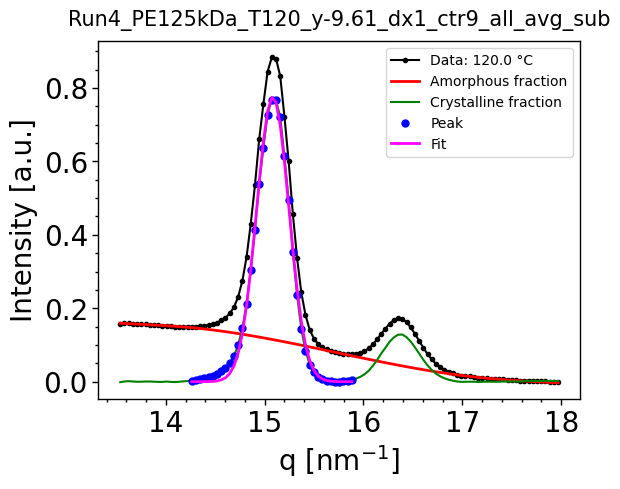

11
Processing file: Run4_PE125kDa_T130_y-9.61_dx1_ctr10_all_avg_sub.dat
Percentage crystallinity: 14.44 ± 0.16 %
Figure saved as: /Users/akmaurya/Library/CloudStorage/OneDrive-Stanford/Data_01/Autoxidation_2023/Autoxidation_Water_Part2/OneD_integrated_WAXS_01/Analysis/Figures/Run4_PE125kDa_T130_y-_fit.png


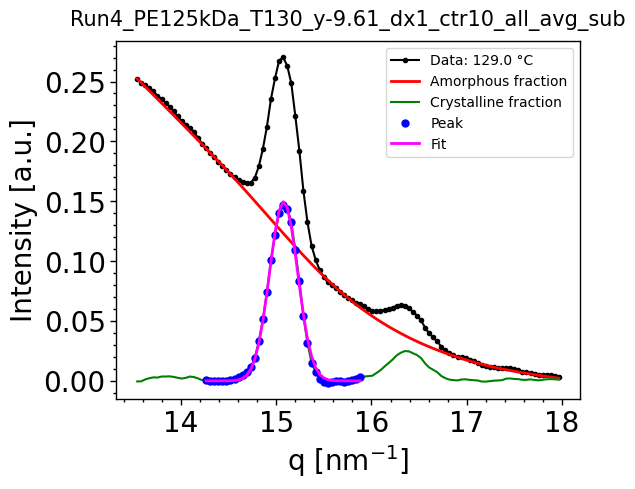

12
Processing file: Run4_PE125kDa_T140_y-9.61_dx1_ctr11_all_avg_sub.dat
Percentage crystallinity: 0.70 ± 0.17 %
Figure saved as: /Users/akmaurya/Library/CloudStorage/OneDrive-Stanford/Data_01/Autoxidation_2023/Autoxidation_Water_Part2/OneD_integrated_WAXS_01/Analysis/Figures/Run4_PE125kDa_T140_y-_fit.png


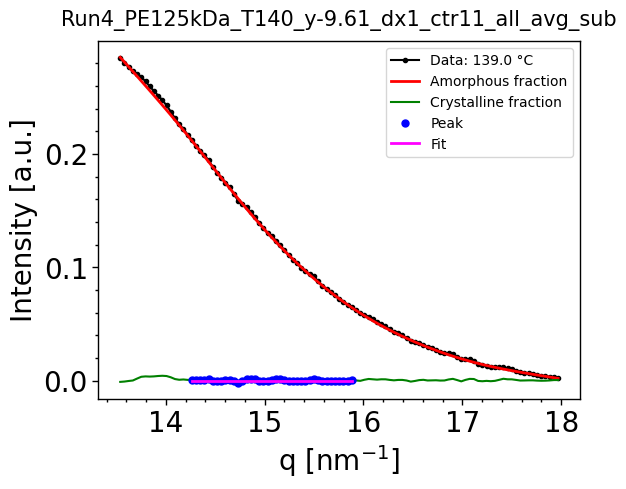

13
Processing file: Run4_PE125kDa_T150_y-9.61_dx1_ctr12_all_avg_sub.dat
Percentage crystallinity: 0.60 ± 0.17 %
Figure saved as: /Users/akmaurya/Library/CloudStorage/OneDrive-Stanford/Data_01/Autoxidation_2023/Autoxidation_Water_Part2/OneD_integrated_WAXS_01/Analysis/Figures/Run4_PE125kDa_T150_y-_fit.png


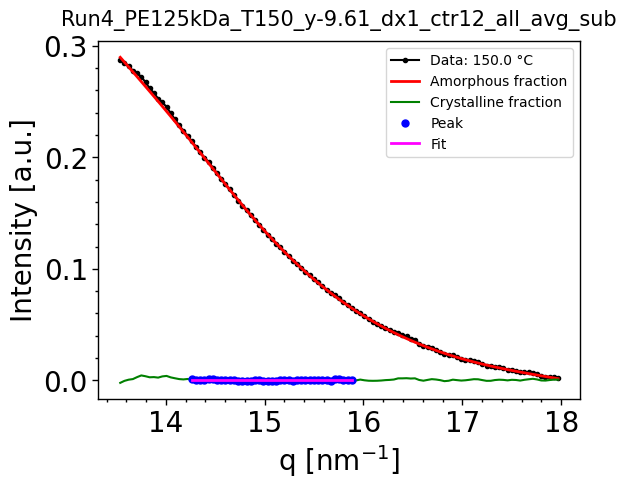

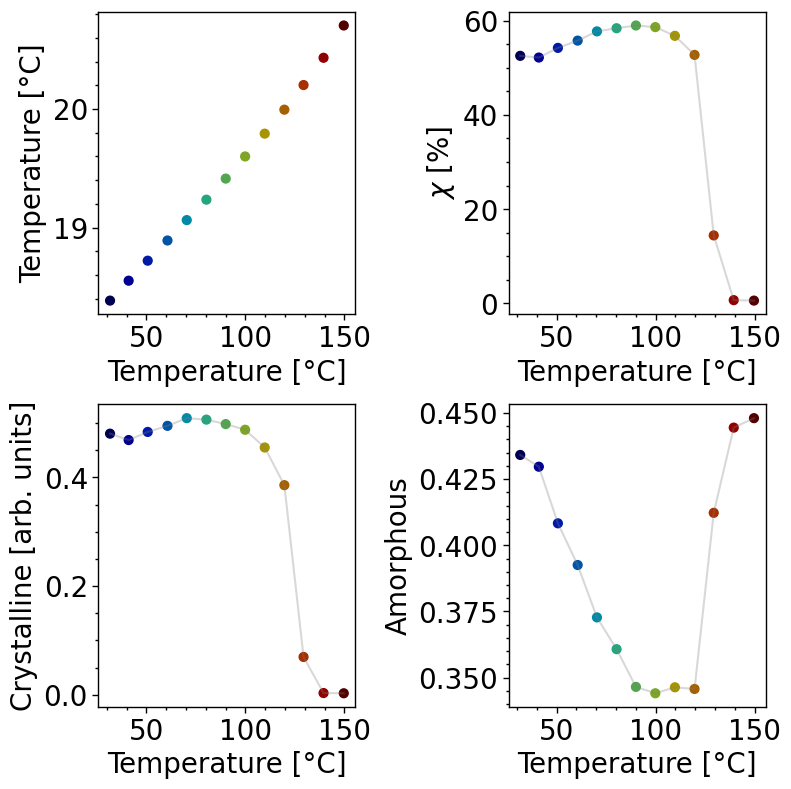

/var/folders/0q/m0d3p44n2cb5dg956r2m2f782yh1mf/T/ipykernel_29208/2438528513.py:230: RuntimeWarning: divide by zero encountered in divide
  size = 0.9 * (1.0 / np.array(fwhm_list)) * 2 * np.pi


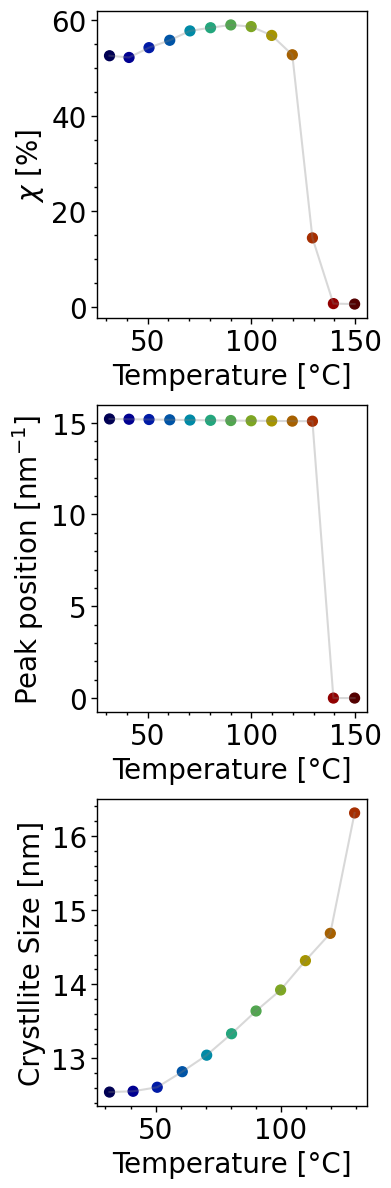

In [35]:
keyword="Run4_PE125kDa_T"

Run4_PE=process_WAXS_data(WAXS_sub_files, keyword, num_files_to_plot, start_index, num_ave_files, min_q_value, max_q_value, qmin_peak, qmax_peak, fit_function, peak_threshold, smmoth_window_size, offset_factor, lam, porder, itermax, save_fitted_results,
                      darker_colors, fonts=20, xvar_plot=None)


# Plot all

/var/folders/0q/m0d3p44n2cb5dg956r2m2f782yh1mf/T/ipykernel_29208/4023943757.py:29: RuntimeWarning: divide by zero encountered in divide
  d_raun1 =  10 *2*np.pi/peak_position_list_run1
/var/folders/0q/m0d3p44n2cb5dg956r2m2f782yh1mf/T/ipykernel_29208/4023943757.py:30: RuntimeWarning: divide by zero encountered in divide
  d_raun2 =  10 *2*np.pi/peak_position_list_run2
/var/folders/0q/m0d3p44n2cb5dg956r2m2f782yh1mf/T/ipykernel_29208/4023943757.py:31: RuntimeWarning: divide by zero encountered in divide
  d_raun3 =  10 *2*np.pi/peak_position_list_run3
/var/folders/0q/m0d3p44n2cb5dg956r2m2f782yh1mf/T/ipykernel_29208/4023943757.py:32: RuntimeWarning: divide by zero encountered in divide
  d_raun4 =  10 *2*np.pi/peak_position_list_run4


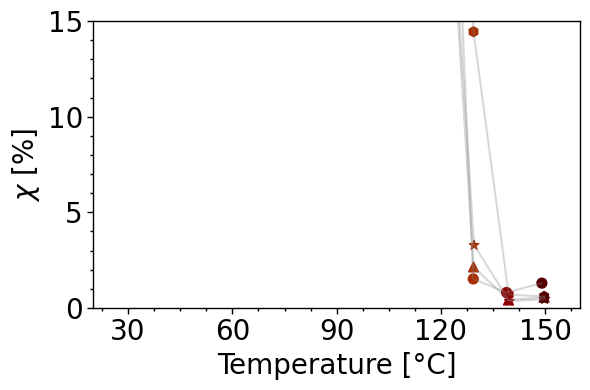

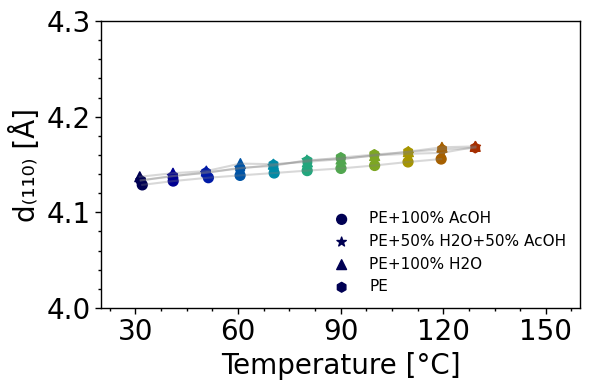

/var/folders/0q/m0d3p44n2cb5dg956r2m2f782yh1mf/T/ipykernel_29208/4023943757.py:66: RuntimeWarning: divide by zero encountered in divide
  size_run1 =  0.9 * (1.0 / np.array(fwhm_list_run1)) * 2 * np.pi
/var/folders/0q/m0d3p44n2cb5dg956r2m2f782yh1mf/T/ipykernel_29208/4023943757.py:67: RuntimeWarning: divide by zero encountered in divide
  size_run2 = 0.9 * (1.0 / np.array(fwhm_list_run2)) * 2 * np.pi
/var/folders/0q/m0d3p44n2cb5dg956r2m2f782yh1mf/T/ipykernel_29208/4023943757.py:68: RuntimeWarning: divide by zero encountered in divide
  size_run3 =0.9 * (1.0 / np.array(fwhm_list_run3)) * 2 * np.pi
/var/folders/0q/m0d3p44n2cb5dg956r2m2f782yh1mf/T/ipykernel_29208/4023943757.py:69: RuntimeWarning: divide by zero encountered in divide
  size_run4 = 0.9 * (1.0 / np.array(fwhm_list_run4)) * 2 * np.pi


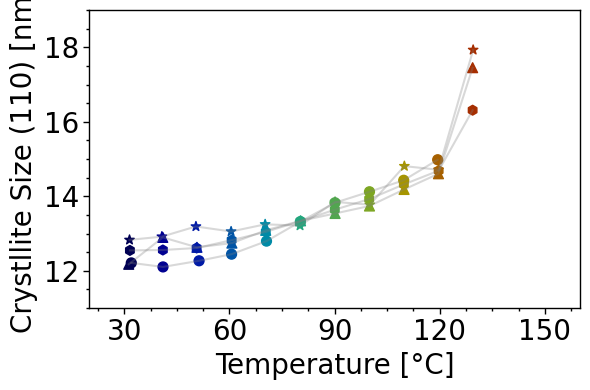

In [36]:
fig, (axs0) = plt.subplots(1,1, figsize=(6, 4),sharex=True)

axs0.plot(Run1_PE_water00['CTEMP_values'], Run1_PE_water00['percentage_crytallinity'], linestyle='-', color="grey", markersize=3, alpha=0.3)
axs0.plot(Run2_PE_water50['CTEMP_values'], Run2_PE_water50['percentage_crytallinity'], linestyle='-', color="grey", markersize=3, alpha=0.3)
axs0.plot(Run3_PE_water100['CTEMP_values'], Run3_PE_water100['percentage_crytallinity'], linestyle='-', color="grey", markersize=3, alpha=0.3)
axs0.plot(Run4_PE['CTEMP_values'], Run4_PE['percentage_crytallinity'], linestyle='-', color="grey", markersize=3, alpha=0.3)
axs0.scatter(Run1_PE_water00['CTEMP_values'], Run1_PE_water00['percentage_crytallinity'], marker='o', s=50, c=darker_colors[:len(Run1_PE_water00['CTEMP_values'])], label='PE_water00')
axs0.scatter(Run2_PE_water50['CTEMP_values'], Run2_PE_water50['percentage_crytallinity'], marker='*', s=50, c=darker_colors[:len(Run2_PE_water50['CTEMP_values'])], label='PE_water50')
axs0.scatter(Run3_PE_water100['CTEMP_values'], Run3_PE_water100['percentage_crytallinity'], marker='^', s=50, c=darker_colors[:len(Run3_PE_water100['CTEMP_values'])], label='PE_water100')
axs0.scatter(Run4_PE['CTEMP_values'], Run4_PE['percentage_crytallinity'], marker='h', s=50, c=darker_colors[:len(Run4_PE['CTEMP_values'])], label='PE')

set_plot_style(axs0, 20, "Temperature [°C]",'$\chi$ [$\%$]')
#axs0.legend(loc='upper right', fontsize=10, frameon=False)
axs0.set_xlim(20, 160)
axs0.set_ylim(0, 15)
axs0.set_xticks([30, 60, 90, 120, 150])    
axs0.set_xticklabels(['30', '60', '90', '120', '150'])
plt.tight_layout()
plt.savefig(save_fitted_results + "/" + "WAXS_fititng parameters_chi.png", dpi=400)

fig2, (axs1) = plt.subplots(1,1, figsize=(6, 4),sharex=True)


peak_position_list_run1 = np.array(Run1_PE_water00['peak_position_list'])
peak_position_list_run2 = np.array(Run2_PE_water50['peak_position_list'])
peak_position_list_run3 = np.array(Run3_PE_water100['peak_position_list'])
peak_position_list_run4 = np.array(Run4_PE['peak_position_list'])

d_raun1 =  10 *2*np.pi/peak_position_list_run1
d_raun2 =  10 *2*np.pi/peak_position_list_run2
d_raun3 =  10 *2*np.pi/peak_position_list_run3
d_raun4 =  10 *2*np.pi/peak_position_list_run4

axs1.plot(Run1_PE_water00['CTEMP_values'], d_raun1, linestyle='-', color="grey", markersize=3, alpha=0.3)
axs1.plot(Run2_PE_water50['CTEMP_values'], d_raun2, linestyle='-', color="grey", markersize=3, alpha=0.3)
axs1.plot(Run3_PE_water100['CTEMP_values'], d_raun3, linestyle='-', color="grey", markersize=3, alpha=0.3)
axs1.plot(Run4_PE['CTEMP_values'], d_raun4, linestyle='-', color="grey", markersize=3, alpha=0.3)

axs1.scatter(Run1_PE_water00['CTEMP_values'], d_raun1, marker='o', s=50, c=darker_colors[:len(Run1_PE_water00['CTEMP_values'])], label='PE+100% AcOH')
axs1.scatter(Run2_PE_water50['CTEMP_values'], d_raun2, marker='*', s=50, c=darker_colors[:len(Run2_PE_water50['CTEMP_values'])], label='PE+50% H2O+50% AcOH')
axs1.scatter(Run3_PE_water100['CTEMP_values'], d_raun3, marker='^', s=50, c=darker_colors[:len(Run3_PE_water100['CTEMP_values'])], label='PE+100% H2O')
axs1.scatter(Run4_PE['CTEMP_values'], d_raun4, marker='h', s=50, c=darker_colors[:len(Run4_PE['CTEMP_values'])], label='PE')
axs1.legend(loc='lower right', fontsize=11, frameon=False)
#set_plot_style(axs1, 20, "Temperature [°C]" ,'d₍₂₀₀₎ [Å]')
#d110
set_plot_style(axs1, 20, "Temperature [°C]",'d₍₁₁₀₎ [Å]')


axs1.set_xlim(20, 160)
axs1.set_xticks([30, 60, 90, 120, 150])    
axs1.set_xticklabels(['30', '60', '90', '120', '150'])
#axs1.set_ylim(16.34, 16.9)
axs1.set_ylim(4.0, 4.3)
plt.tight_layout()
plt.savefig(save_fitted_results + "/" + "WAXS_fititng parameters_peakposition_110.png", dpi=400)
plt.show()

fig3, (axs2) = plt.subplots(1,1, figsize=(6, 4),sharex=True)


fwhm_list_run1 = np.array(Run1_PE_water00['fwhm_list'])
fwhm_list_run2 = np.array(Run2_PE_water50['fwhm_list'])
fwhm_list_run3 = np.array(Run3_PE_water100['fwhm_list'])
fwhm_list_run4 = np.array(Run4_PE['fwhm_list'])

size_run1 =  0.9 * (1.0 / np.array(fwhm_list_run1)) * 2 * np.pi
size_run2 = 0.9 * (1.0 / np.array(fwhm_list_run2)) * 2 * np.pi
size_run3 =0.9 * (1.0 / np.array(fwhm_list_run3)) * 2 * np.pi
size_run4 = 0.9 * (1.0 / np.array(fwhm_list_run4)) * 2 * np.pi

axs2.plot(Run1_PE_water00['CTEMP_values'], size_run1, linestyle='-', color="grey", markersize=3, alpha=0.3)
axs2.plot(Run2_PE_water50['CTEMP_values'], size_run2, linestyle='-', color="grey", markersize=3, alpha=0.3)
axs2.plot(Run3_PE_water100['CTEMP_values'], size_run3, linestyle='-', color="grey", markersize=3, alpha=0.3)
axs2.plot(Run4_PE['CTEMP_values'], size_run4, linestyle='-', color="grey", markersize=3, alpha=0.3)

axs2.scatter(Run1_PE_water00['CTEMP_values'], size_run1, marker='o', s=50, c=darker_colors[:len(Run1_PE_water00['CTEMP_values'])])
axs2.scatter(Run2_PE_water50['CTEMP_values'], size_run2, marker='*', s=50, c=darker_colors[:len(Run2_PE_water50['CTEMP_values'])])
axs2.scatter(Run3_PE_water100['CTEMP_values'], size_run3, marker='^', s=50, c=darker_colors[:len(Run3_PE_water100['CTEMP_values'])])
axs2.scatter(Run4_PE['CTEMP_values'], size_run4, marker='h', s=50, c=darker_colors[:len(Run4_PE['CTEMP_values'])])

set_plot_style(axs2, 20, "Temperature [°C]", 'Crystllite Size (110) [nm]')
axs2.set_xlim(20, 160)
#axs2.get_xticklabels(30,60,90,120,150)
#axs2.set_ylim(10, 14)
axs2.set_ylim(11, 19)
axs2.set_xticks([30, 60, 90, 120, 150])    
axs2.set_xticklabels(['30', '60', '90', '120', '150'])

plt.tight_layout()

plt.savefig(save_fitted_results + "/" + "WAXS_fititng parameters_size_110.png", dpi=400)

plt.show()
